In [10]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import readligo as rl
from gwpy.timeseries import TimeSeries
import math
import random
from matplotlib.lines import Line2D

from scipy import integrate
from sklearn.metrics import auc

import time

In [8]:
epochs = 100
test_sample_ratio = .2
validation_sample_ratio = 0.1
batch_size = 32
coef_delta = 0

noise_ratio = 0.9
bbh_ratio = 0.1

rTrain = 0.7
rTest = 0.2

## Setting global functions

### Weakly Supervised Learning DNN

In [71]:
class SupervisedModel(nn.Module):
    def __init__(self):
        super(SupervisedModel, self).__init__()
        self.fc1 = nn.Linear(200, 64)  # 第一层全连接层，输入维度为4，输出维度为64
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(64, 16)  # 第二层全连接层，输入维度为64，输出维度为32
        self.fc3 = nn.Linear(16, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        # x = self.sigmoid(x)
        return x

In [22]:
class SupervisedModel(nn.Module):
    def __init__(self):
        super(SupervisedModel, self).__init__()
        self.fc1 = nn.Linear(200, 64)  # 第一层全连接层，输入维度为4，输出维度为64
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(64, 64)  # 第二层全连接层，输入维度为64，输出维度为32
        self.fc3 = nn.Linear(64, 16)  # 第二层全连接层，输入维度为64，输出维度为32
        self.fc4 = nn.Linear(16, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

In [46]:
class SupervisedModel(nn.Module):
    def __init__(self):
        super(SupervisedModel, self).__init__()
        self.fc1 = nn.Linear(200, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc4(x)
        # x = self.relu(x)
        x = self.sigmoid(x)
        return x

In [135]:
classifier

SupervisedModel(
  (fc1): Linear(in_features=200, out_features=64, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

In [5]:
def normalize(v):
    norm = np.linalg.norm(v)
    junk = 0
    if norm == 0: 
       return v, junk, norm
    return v / norm, junk, norm

def bunch_normalization(v_set):
    recover_min = list(range(len(v_set)))
    recover_coef = list(range(len(v_set)))
    v_set_normalized = np.zeros((v_set.shape[0], v_set.shape[1]))
    for i in range(len(v_set)):
        v_set_normalized[i], recover_min[i], recover_coef[i] = normalize(v_set[i])
    return v_set_normalized, recover_min, recover_coef

In [4]:
def standarization(realbkg_trimmed):
    realbkg_trimmed = (realbkg_trimmed - np.transpose([np.mean(realbkg_trimmed, axis=1)]))/np.transpose([np.std(realbkg_trimmed, axis=1)])
    return realbkg_trimmed

In [72]:
def count_trainable_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

# 示例用法
model = SupervisedModel()  # 替换为你的模型
total_params = count_trainable_parameters(model)
print("Total trainable parameters in the model:", total_params)

Total trainable parameters in the model: 13921


## Introducing the data to use

In [156]:
data_noise = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/background.npz')['data'][:,0,:]

In [157]:
data_bbh = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy')[:,0,:]

In [147]:
labels_noise = np.zeros(len(data_noise)).reshape(-1,1)

In [148]:
labels_bbh = np.ones(len(data_bbh)).reshape(-1,1)

In [158]:
data_noise = data_noise / 20

In [159]:
data_bbh = data_bbh / 20

In [160]:
data_noise_normalized,_,_ = bunch_normalization(data_noise)
data_bbh_normalized,_,_ = bunch_normalization(data_bbh)

In [152]:
data_noise_normalized = np.hstack((data_noise_normalized, labels_noise))
data_bbh_normalized = np.hstack((data_bbh_normalized, labels_bbh))

In [126]:
noise_count = int(len(data_noise) * noise_ratio)
bbh_count = int(len(data_bbh) * bbh_ratio)

In [266]:
total_count = noise_count + bbh_count
train_size = int(total_count * 0.7)
validation_size = int(total_count * 0.1)
test_size = total_count - train_size - validation_size

In [119]:
# 从 data_noise 中选择对应占比的元素
selected_noise_indices = np.random.choice(len(data_noise), size=noise_count, replace=False)
selected_noise = data_noise[selected_noise_indices]

# 从 data_bbh 中选择对应占比的元素
selected_bbh_indices = np.random.choice(len(data_bbh), size=bbh_count, replace=False)
selected_bbh = data_bbh[selected_bbh_indices]

# 获取 train_set 中 bbh 和 noise 的索引
train_bbh_indices = selected_bbh_indices[:int(train_size * bbh_ratio)]
train_noise_indices = selected_noise_indices[:int(train_size * noise_ratio)]

# 获取 validation_set 中 bbh 和 noise 的索引
validation_bbh_indices = selected_bbh_indices[int(train_size * bbh_ratio):int((train_size + validation_size) * bbh_ratio)]
validation_noise_indices = selected_noise_indices[int(train_size * noise_ratio):int((train_size + validation_size) * noise_ratio)]

# 获取 test_set 中 bbh 和 noise 的索引
test_bbh_indices = selected_bbh_indices[int((train_size + validation_size) * bbh_ratio):]
test_noise_indices = selected_noise_indices[int((train_size + validation_size) * noise_ratio):]

In [121]:
train_set_permutation = np.random.choice(train_size,size = train_size, replace = False)
test_set_permutation = np.random.choice(test_size,size = test_size, replace = False)
validation_set_permutation = np.random.choice(validation_size,size = validation_size, replace = False)

In [128]:
trainData = torch.FloatTensor(np.vstack((data_noise_normalized[train_noise_indices], data_bbh_normalized[train_bbh_indices]))[train_set_permutation])
testData = torch.FloatTensor(np.vstack((data_noise_normalized[test_noise_indices], data_bbh_normalized[test_bbh_indices]))[test_set_permutation])
validationData = torch.FloatTensor(np.vstack((data_noise_normalized[validation_noise_indices], data_bbh_normalized[validation_bbh_indices]))[validation_set_permutation])

In [268]:
indices = np.load('../Data_cached/indices_for_weakly_supervised_training_1e-1_test_noise.npz')

In [269]:
bbh_signal_indices = indices['bbh_signal_indices']
bbh_noise_indices = indices['bbh_noise_indices']
bkg_signal_indices = indices['bkg_signal_indices']
bkg_noise_indices = indices['bkg_noise_indices']

In [267]:
test_size

20000

In [222]:
noise_sample = np.vstack((data_noise_normalized[:train_size][bkg_noise_indices], data_bbh_normalized[bbh_noise_indices]))
signal_sample = np.vstack((data_noise_normalized[:train_size][bkg_signal_indices], data_bbh_normalized[bbh_signal_indices]))

In [348]:
signal_sample = np.vstack((data_noise_normalized[-test_size:][bkg_signal_indices], data_bbh_normalized[bbh_signal_indices[:1000]]))

In [298]:
random_indices = np.random.choice(len(data_bbh_normalized), size = int(0.5 * len(data_bbh_normalized)), replace = False)
random_indices_complementary = np.setdiff1d(np.arange(len(data_bbh_normalized)), random_indices)

In [299]:
signal_sample = data_bbh_normalized[random_indices]

In [321]:
noise_sample = data_noise_normalized[:train_size]

In [329]:
noise_sample = noise_sample.reshape(-1,200)
signal_sample = signal_sample.reshape(-1,200)

In [323]:
noise_sample_labeled = np.hstack((noise_sample, np.zeros((len(noise_sample),1))))
noise_sample_labeled.shape

(70000, 201)

In [324]:
noise_sample_labeled

array([[ 0.08945929,  0.08077274,  0.05655106, ...,
        -0.02723498,  0.01550925,  0.        ],
       [ 0.04399108,  0.01299934, -0.01668372, ...,
         0.00264529,  0.0992666 ,  0.        ],
       [-0.01058523, -0.03140058,  0.03486606, ...,
        -0.01974322,  0.04920299,  0.        ],
       ...,
       [-0.06799496, -0.01070641, -0.02476252, ...,
         0.10492589, -0.04670127,  0.        ],
       [ 0.02656637,  0.14939621, -0.01686036, ...,
        -0.09681784, -0.03242174,  0.        ],
       [ 0.03072589,  0.07958879,  0.02969357, ...,
        -0.02392232,  0.12997317,  0.        ]])

In [330]:
signal_sample_labeled = np.hstack((signal_sample, np.ones((len(signal_sample),1))))
signal_sample_labeled.shape

(2332, 201)

In [331]:
signal_sample_labeled

array([[-0.02790723,  0.02429213,  0.03103033, ...,
         0.06756967,  0.03583609,  1.        ],
       [-0.04750014, -0.05944677, -0.04010478, ...,
        -0.1497448 , -0.04711631,  1.        ],
       [-0.00234438,  0.07914928, -0.05213563, ...,
        -0.05097333,  0.02864983,  1.        ],
       ...,
       [-0.06439101, -0.18801743, -0.04959967, ...,
         0.00715289, -0.04442066,  1.        ],
       [-0.08408728, -0.04743954,  0.12010511, ...,
         0.0625576 ,  0.10051753,  1.        ],
       [-0.0468615 ,  0.01090898, -0.02307885, ...,
        -0.00798532, -0.09000536,  1.        ]])

In [332]:
permutation = np.random.choice(len(noise_sample_labeled) + len(signal_sample_labeled), size = len(noise_sample_labeled) + len(signal_sample_labeled), replace=False)

In [333]:
permutation.shape

(72332,)

In [91]:
FulltrainingROCbbh = np.loadtxt('../Data_cached/ROC_bbh.dat')
FulltrainingROCsg = np.loadtxt('../Data_cached/ROC_sg.dat')

### This is the data from glitches_included model and glitches included noise

In [6]:
data_train_ini = np.load('../Data_cached/data_for_wekaly_supervised_learning.npz')['noise_sample']

In [7]:
data_signal_noise_ini = np.load('../Data_cached/data_for_wekaly_supervised_learning.npz')['signal_sample_noise']
data_signal_bbh_ini = np.load('../Data_cached/data_for_wekaly_supervised_learning.npz')['signal_sample_bbh']

In [8]:
data_full_noise_ini = np.load('../Data_cached/data_for_wekaly_supervised_learning.npz')['full_noise_sample']
data_full_bbh_ini = np.load('../Data_cached/data_for_wekaly_supervised_learning.npz')['full_bbh_sample']

In [168]:
data_train_ini = np.load('../Data_cached/data_for_wekaly_supervised_learning_sinegaussian.npz')['noise_sample']
data_signal_noise_ini = np.load('../Data_cached/data_for_wekaly_supervised_learning_sinegaussian.npz')['signal_sample_noise']
data_signal_bbh_ini = np.load('../Data_cached/data_for_wekaly_supervised_learning_sinegaussian.npz')['signal_sample_sg']
data_full_noise_ini = np.load('../Data_cached/data_for_wekaly_supervised_learning_sinegaussian.npz')['full_noise_sample']
data_full_bbh_ini = np.load('../Data_cached/data_for_wekaly_supervised_learning_sinegaussian.npz')['full_sg_sample']

In [169]:
data_train = standarization(data_train_ini.copy())
data_signal_noise = standarization(data_signal_noise_ini.copy())
data_signal_bbh = standarization(data_signal_bbh_ini.copy())
data_full_noise = standarization(data_full_noise_ini.copy())
data_full_bbh = standarization(data_full_bbh_ini.copy())

In [111]:
data_train_ini.shape

(70070, 200)

In [112]:
data_signal_noise.shape

(2003, 200)

In [116]:
data_signal_bbh.shape

(47274, 200)

In [59]:
def upperTPRFPRcalc(trainerror, signalerror, FPRlist):
    TPRlist = np.zeros(len(FPRlist))
    length_of_train_sample = len(trainerror)
    print(length_of_train_sample)
    length_of_signal_value = len(signalerror)
    print(length_of_signal_value)
    
    for i in range(len(FPRlist)):
        index_number = int(length_of_train_sample * FPRlist[i])
        threshold = np.sort(trainerror)[-index_number]
            
        # print(threshold)
        # print(np.argwhere(signalerror >= threshold).shape)
        TPRlist[i] = np.argwhere(signalerror > threshold).shape[0] / length_of_signal_value
    
    TPRlist[-1] = 1
    
    return TPRlist

def lowerTPRFPRcalc(trainerror, signalerror, FPRlist):
    TPRlist = np.zeros(len(FPRlist))
    length_of_train_sample = len(trainerror)
    # print(length_of_train_sample)
    length_of_signal_value = len(signalerror)
    # print(length_of_signal_value)
    
    for i in range(len(FPRlist)):
        index_number = int(length_of_train_sample * FPRlist[i])
        if index_number == 0:
            threshold = np.sort(trainerror)[index_number]
        else:
            threshold = np.sort(trainerror)[index_number-1]
        # print(np.sort(trainerror))
        # print(threshold)
        # print(np.argwhere(signalerror < threshold).shape)
        TPRlist[i] = np.argwhere(signalerror < threshold).shape[0] / length_of_signal_value
    
    TPRlist[-1] = 1
    
    return TPRlist

FPR_list = np.logspace(-3,0,100)

In [114]:
# 1

renorm_factor = 20;

realbkg = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/background.npz")['data'] / renorm_factor;
realbbh = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy") / renorm_factor;

realsg = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy") / renorm_factor;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"] / 12.3

realbkg_trimmed = realbkg[:, 0];
realbbh_trimmed = realbbh[:, 0];
realsg_trimmed  = realsg[:, 0];

realbkg_trimmed = (realbkg_trimmed - np.transpose([np.mean(realbkg_trimmed, axis=1)]))/np.transpose([np.std(realbkg_trimmed, axis=1)]);
realbbh_trimmed = (realbbh_trimmed - np.transpose([np.mean(realbbh_trimmed, axis=1)]))/np.transpose([np.std(realbbh_trimmed, axis=1)]);
realsg_trimmed  = (realsg_trimmed  - np.transpose([np.mean(realsg_trimmed , axis=1)]))/np.transpose([np.std(realsg_trimmed,  axis=1)]);

realglitch_trimmed = (realglitch - np.transpose([np.mean(realglitch, axis=1)]))/np.transpose([np.std(realglitch, axis=1)])

dInput = realbkg_trimmed.shape[1]

nTotal = len(realbbh_trimmed);
nTrain = int(rTrain * nTotal)
nTest  = int(rTest * nTotal)
nValid = nTotal - nTrain - nTest;

nTrain_ns = int(0.4*nTrain)
nTest_ns = int(0.4*nTest)
nValid_ns = int(0.4*nValid)

nTrain_g = int(0.2*nTrain)
nTest_g = int(0.2*nTest)
nValid_g = int(0.2*nValid)

X_train = np.empty((nTrain + 2*nTrain_ns + nTrain_g, dInput))
X_test  = np.empty((nTest + 2*nTest_ns + nTest_g,  dInput))
X_valid = np.empty((nValid + 2*nValid_ns + nValid_g, dInput))

target_train = np.zeros((nTrain + 2*nTrain_ns + nTrain_g, ), dtype="int64")
target_test  = np.zeros((nTest + 2*nTest_ns + nTest_g, ), dtype="int64")
target_valid = np.zeros((nValid + 2*nValid_ns + nValid_g, ), dtype="int64")

# permBKG = np.random.permutation(nTotal)
# permBBH = np.random.permutation(nTotal)
# permSG  = np.random.permutation(nTotal)
# permGLITCH = np.random.permutation(len(realglitch_trimmed))

# np.savetxt("../Data_cached/SupLearn/permDNN_BKG.dat", permBKG)
# np.savetxt("../Data_cached/SupLearn/permDNN_BBH.dat", permBBH)
# np.savetxt("../Data_cached/SupLearn/permDNN_SG.dat", permSG)
# np.savetxt("../Data_cached/SupLearn/permDNN_GLITCH.dat", permGLITCH)

permBKG = np.genfromtxt("../Data_cached/SupLearn/permDNN_BKG.dat").astype(int)
permBBH = np.genfromtxt("../Data_cached/SupLearn/permDNN_BBH.dat").astype(int)
permSG = np.genfromtxt("../Data_cached/SupLearn/permDNN_SG.dat").astype(int)
permGLITCH = np.genfromtxt("../Data_cached/SupLearn/permDNN_GLITCH.dat").astype(int)

# initializing the training set
X_train[ : nTrain] = realbbh_trimmed[permBBH[:nTrain]]
X_train[nTrain : nTrain+nTrain_ns] = realbkg_trimmed[permBKG[:nTrain_ns]]
X_train[nTrain+nTrain_ns : nTrain+2*nTrain_ns] = realsg_trimmed[permSG[:nTrain_ns]]
X_train[nTrain+2*nTrain_ns : ] = realglitch_trimmed[permGLITCH[:nTrain_g]]

target_train[:nTrain] = 1;

# initializing the test set
X_test[ : nTest] = realbbh_trimmed[permBBH[-nTest:]]
X_test[nTest : nTest+nTest_ns] = realbkg_trimmed[permBKG[-nTest_ns:]]
X_test[nTest+nTest_ns : nTest+2*nTest_ns] = realsg_trimmed[permSG[-nTest_ns:]]
X_test[nTest+2*nTest_ns : ] = realglitch_trimmed[permGLITCH[-nTest_g:]]

target_test[:nTest] = 1;

# initializing the validation set
X_valid[:nValid] = realbbh_trimmed[permBBH[nTrain : -nTest]]
X_valid[nValid : nValid+nValid_ns] = realbkg_trimmed[permBKG[nTrain_ns : nTrain_ns+nValid_ns]]
X_valid[nValid+nValid_ns : nValid+2*nValid_ns] = realsg_trimmed[permSG[nTrain_ns : nTrain_ns+nValid_ns]]
X_valid[nValid+2*nValid_ns : ] = realglitch_trimmed[permGLITCH[nTrain_g : nTrain_g+nValid_g]]

target_valid[:nValid] = 1;

train_dataset = TensorDataset(torch.FloatTensor(X_train.reshape((X_train.shape[0], X_train.shape[1]))), torch.FloatTensor(target_train.reshape((len(target_train)),1)))
test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test)),1)))
valid_dataset = TensorDataset(torch.FloatTensor(X_valid.reshape((X_valid.shape[0], X_valid.shape[1]))), torch.FloatTensor(target_valid.reshape((len(target_valid)),1)))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

In [119]:
# 2

renorm_factor = 20;

realbkg = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/background.npz")['data'] / renorm_factor;
realsg = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy") / renorm_factor;

realbbh = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy") / renorm_factor;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"] / 12.3

realbkg_trimmed = realbkg[:, 0];
realbbh_trimmed = realbbh[:, 0];
realsg_trimmed  = realsg[:, 0];

realbkg_trimmed = (realbkg_trimmed - np.transpose([np.mean(realbkg_trimmed, axis=1)]))/np.transpose([np.std(realbkg_trimmed, axis=1)]);
realbbh_trimmed = (realbbh_trimmed - np.transpose([np.mean(realbbh_trimmed, axis=1)]))/np.transpose([np.std(realbbh_trimmed, axis=1)]);
realsg_trimmed  = (realsg_trimmed  - np.transpose([np.mean(realsg_trimmed , axis=1)]))/np.transpose([np.std(realsg_trimmed,  axis=1)]);

realglitch_trimmed = (realglitch - np.transpose([np.mean(realglitch, axis=1)]))/np.transpose([np.std(realglitch, axis=1)])

dInput = realbkg_trimmed.shape[1]

nTotal = len(realbbh_trimmed);
nTrain = int(rTrain * nTotal)
nTest  = int(rTest * nTotal)
nValid = nTotal - nTrain - nTest;

nTrain_ns = int(0.4*nTrain)
nTest_ns = int(0.4*nTest)
nValid_ns = int(0.4*nValid)

nTrain_g = int(0.2*nTrain)
nTest_g = int(0.2*nTest)
nValid_g = int(0.2*nValid)

X_train = np.empty((nTrain + 2*nTrain_ns + nTrain_g, dInput))
X_test  = np.empty((nTest + 2*nTest_ns + nTest_g,  dInput))
X_valid = np.empty((nValid + 2*nValid_ns + nValid_g, dInput))

target_train = np.zeros((nTrain + 2*nTrain_ns + nTrain_g, ), dtype="int64")
target_test  = np.zeros((nTest + 2*nTest_ns + nTest_g, ), dtype="int64")
target_valid = np.zeros((nValid + 2*nValid_ns + nValid_g, ), dtype="int64")

# permBKG = np.random.permutation(nTotal)
# permBBH = np.random.permutation(nTotal)
# permSG  = np.random.permutation(nTotal)
# permGLITCH = np.random.permutation(len(realglitch_trimmed))

# np.savetxt("../Data_cached/SupLearn/permDNN_BKG_1.dat", permBKG)
# np.savetxt("../Data_cached/SupLearn/permDNN_BBH_1.dat", permBBH)
# np.savetxt("../Data_cached/SupLearn/permDNN_SG_1.dat", permSG)
# np.savetxt("../Data_cached/SupLearn/permDNN_GLITCH_1.dat", permGLITCH)

permBKG = np.genfromtxt("../Data_cached/SupLearn/permDNN_BKG_1.dat").astype(int)
permBBH = np.genfromtxt("../Data_cached/SupLearn/permDNN_BBH_1.dat").astype(int)
permSG = np.genfromtxt("../Data_cached/SupLearn/permDNN_SG_1.dat").astype(int)
permGLITCH = np.genfromtxt("../Data_cached/SupLearn/permDNN_GLITCH_1.dat").astype(int)

# initializing the training set
X_train[ : nTrain] = realbbh_trimmed[permBBH[:nTrain]]
X_train[nTrain : nTrain+nTrain_ns] = realbkg_trimmed[permBKG[:nTrain_ns]]
X_train[nTrain+nTrain_ns : nTrain+2*nTrain_ns] = realsg_trimmed[permSG[:nTrain_ns]]
X_train[nTrain+2*nTrain_ns : ] = realglitch_trimmed[permGLITCH[:nTrain_g]]

target_train[:nTrain] = 1;

# initializing the test set
X_test[ : nTest] = realbbh_trimmed[permBBH[-nTest:]]
X_test[nTest : nTest+nTest_ns] = realbkg_trimmed[permBKG[-nTest_ns:]]
X_test[nTest+nTest_ns : nTest+2*nTest_ns] = realsg_trimmed[permSG[-nTest_ns:]]
X_test[nTest+2*nTest_ns : ] = realglitch_trimmed[permGLITCH[-nTest_g:]]

target_test[:nTest] = 1;

# initializing the validation set
X_valid[:nValid] = realbbh_trimmed[permBBH[nTrain : -nTest]]
X_valid[nValid : nValid+nValid_ns] = realbkg_trimmed[permBKG[nTrain_ns : nTrain_ns+nValid_ns]]
X_valid[nValid+nValid_ns : nValid+2*nValid_ns] = realsg_trimmed[permSG[nTrain_ns : nTrain_ns+nValid_ns]]
X_valid[nValid+2*nValid_ns : ] = realglitch_trimmed[permGLITCH[nTrain_g : nTrain_g+nValid_g]]

target_valid[:nValid] = 1;

train_dataset = TensorDataset(torch.FloatTensor(X_train.reshape((X_train.shape[0], X_train.shape[1]))), torch.FloatTensor(target_train.reshape((len(target_train)),1)))
test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test)),1)))
valid_dataset = TensorDataset(torch.FloatTensor(X_valid.reshape((X_valid.shape[0], X_valid.shape[1]))), torch.FloatTensor(target_valid.reshape((len(target_valid)),1)))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

In [129]:
# 3

renorm_factor = 20;

realbbh = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/background.npz")['data'] / renorm_factor;
realbkg= np.load("E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy") / renorm_factor;

realsg = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy") / renorm_factor;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"] / 12.3

realbkg_trimmed = realbkg[:, 0];
realbbh_trimmed = realbbh[:, 0];
realsg_trimmed  = realsg[:, 0];

realbkg_trimmed = (realbkg_trimmed - np.transpose([np.mean(realbkg_trimmed, axis=1)]))/np.transpose([np.std(realbkg_trimmed, axis=1)]);
realbbh_trimmed = (realbbh_trimmed - np.transpose([np.mean(realbbh_trimmed, axis=1)]))/np.transpose([np.std(realbbh_trimmed, axis=1)]);
realsg_trimmed  = (realsg_trimmed  - np.transpose([np.mean(realsg_trimmed , axis=1)]))/np.transpose([np.std(realsg_trimmed,  axis=1)]);

realglitch_trimmed = (realglitch - np.transpose([np.mean(realglitch, axis=1)]))/np.transpose([np.std(realglitch, axis=1)])

dInput = realbkg_trimmed.shape[1]

nTotal = len(realbbh_trimmed);
nTrain = int(rTrain * nTotal)
nTest  = int(rTest * nTotal)
nValid = nTotal - nTrain - nTest;

nTrain_ns = int(0.4*nTrain)
nTest_ns = int(0.4*nTest)
nValid_ns = int(0.4*nValid)

nTrain_g = int(0.2*nTrain)
nTest_g = int(0.2*nTest)
nValid_g = int(0.2*nValid)

X_train = np.empty((nTrain + 2*nTrain_ns + nTrain_g, dInput))
X_test  = np.empty((nTest + 2*nTest_ns + nTest_g,  dInput))
X_valid = np.empty((nValid + 2*nValid_ns + nValid_g, dInput))

target_train = np.zeros((nTrain + 2*nTrain_ns + nTrain_g, ), dtype="int64")
target_test  = np.zeros((nTest + 2*nTest_ns + nTest_g, ), dtype="int64")
target_valid = np.zeros((nValid + 2*nValid_ns + nValid_g, ), dtype="int64")

# permBKG = np.random.permutation(nTotal)
# permBBH = np.random.permutation(nTotal)
# permSG  = np.random.permutation(nTotal)
# permGLITCH = np.random.permutation(len(realglitch_trimmed))

# np.savetxt("../Data_cached/SupLearn/permDNN_BKG_2.dat", permBKG)
# np.savetxt("../Data_cached/SupLearn/permDNN_BBH_2.dat", permBBH)
# np.savetxt("../Data_cached/SupLearn/permDNN_SG_2.dat", permSG)
# np.savetxt("../Data_cached/SupLearn/permDNN_GLITCH_2.dat", permGLITCH)

permBKG = np.genfromtxt("../Data_cached/SupLearn/permDNN_BKG_2.dat").astype(int)
permBBH = np.genfromtxt("../Data_cached/SupLearn/permDNN_BBH_2.dat").astype(int)
permSG = np.genfromtxt("../Data_cached/SupLearn/permDNN_SG_2.dat").astype(int)
permGLITCH = np.genfromtxt("../Data_cached/SupLearn/permDNN_GLITCH_2.dat").astype(int)

# initializing the training set
X_train[ : nTrain] = realbbh_trimmed[permBBH[:nTrain]]
X_train[nTrain : nTrain+nTrain_ns] = realbkg_trimmed[permBKG[:nTrain_ns]]
X_train[nTrain+nTrain_ns : nTrain+2*nTrain_ns] = realsg_trimmed[permSG[:nTrain_ns]]
X_train[nTrain+2*nTrain_ns : ] = realglitch_trimmed[permGLITCH[:nTrain_g]]

target_train[:nTrain] = 1;
target_train = 1-target_train

# initializing the test set
X_test[ : nTest] = realbbh_trimmed[permBBH[-nTest:]]
X_test[nTest : nTest+nTest_ns] = realbkg_trimmed[permBKG[-nTest_ns:]]
X_test[nTest+nTest_ns : nTest+2*nTest_ns] = realsg_trimmed[permSG[-nTest_ns:]]
X_test[nTest+2*nTest_ns : ] = realglitch_trimmed[permGLITCH[-nTest_g:]]

target_test[:nTest] = 1;

# initializing the validation set
X_valid[:nValid] = realbbh_trimmed[permBBH[nTrain : -nTest]]
X_valid[nValid : nValid+nValid_ns] = realbkg_trimmed[permBKG[nTrain_ns : nTrain_ns+nValid_ns]]
X_valid[nValid+nValid_ns : nValid+2*nValid_ns] = realsg_trimmed[permSG[nTrain_ns : nTrain_ns+nValid_ns]]
X_valid[nValid+2*nValid_ns : ] = realglitch_trimmed[permGLITCH[nTrain_g : nTrain_g+nValid_g]]

target_valid[:nValid] = 1;
target_valid = 1-target_valid

train_dataset = TensorDataset(torch.FloatTensor(X_train.reshape((X_train.shape[0], X_train.shape[1]))), torch.FloatTensor(target_train.reshape((len(target_train)),1)))
test_dataset  = TensorDataset(torch.FloatTensor(X_test.reshape((X_test.shape[0], X_test.shape[1]))),  torch.FloatTensor(target_test.reshape((len(target_test)),1)))
valid_dataset = TensorDataset(torch.FloatTensor(X_valid.reshape((X_valid.shape[0], X_valid.shape[1]))), torch.FloatTensor(target_valid.reshape((len(target_valid)),1)))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

## Training

In [334]:
Final_training_and_validation_set = np.vstack((noise_sample_labeled, signal_sample_labeled))[permutation]

In [335]:
trainData = torch.FloatTensor(Final_training_and_validation_set[:int(0.9 * len(Final_training_and_validation_set))])
validationData = torch.FloatTensor(Final_training_and_validation_set[int(0.9 * len(Final_training_and_validation_set)):])

In [336]:
train_dataset = TensorDataset(trainData, trainData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)


autoencoder = SupervisedModel().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.BCELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))


for epoch in range(epochs):
    # 训练阶段
    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        decoded = autoencoder(x[:,:200])
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x[:,-1])
        # loss_norm = loss_func(decoded[:, -1], x[:, -1])
        
        weighted_lossTrain = loss_overall
        # weighted_lossTrain = loss_overall + loss_norm * coef_delta
        
        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term
        
        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    # 验证阶段
    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            decoded = autoencoder(x[:,:200])
            lossVal_overall = loss_func(decoded, x[:,-1])
            lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
            lossVal = lossVal_overall + lossVal_norm * coef_delta
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)
    
    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
    # print('Epoch: %04d, Training loss=%.8f' % (epoch+1, weighted_lossTrain.item()))
    print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

C:\Users\Liyang Miao\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Liyang Miao\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Liyang Miao\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely

Epoch: 0001, Training loss=0.00105205, Validation loss=0.03046981
Epoch: 0002, Training loss=0.00118340, Validation loss=0.03042979
Epoch: 0003, Training loss=0.00121852, Validation loss=0.03043503
Epoch: 0004, Training loss=0.00123942, Validation loss=0.03041897
Epoch: 0005, Training loss=0.00104869, Validation loss=0.03041921
Epoch: 0006, Training loss=0.00129108, Validation loss=0.03448474
Epoch: 0007, Training loss=0.00102043, Validation loss=0.03041701
Epoch: 0008, Training loss=0.00099917, Validation loss=0.03041017
Epoch: 0009, Training loss=0.00119184, Validation loss=0.03042061
Epoch: 0010, Training loss=0.00100726, Validation loss=0.03042252
Epoch: 0011, Training loss=0.00121801, Validation loss=0.03043905
Epoch: 0012, Training loss=0.00115631, Validation loss=0.03041702
Epoch: 0013, Training loss=0.11825660, Validation loss=0.03041685
Epoch: 0014, Training loss=0.00115952, Validation loss=0.03042012
Epoch: 0015, Training loss=0.00092537, Validation loss=0.03041697
Epoch: 001

13921
Epoch: 0001, Training loss=0.237677, Validation loss=0.280795, valid accuracy=16.000000
4.4049413204193115
Epoch: 0002, Training loss=0.092990, Validation loss=0.227281, valid accuracy=16.000000
4.319448471069336
Epoch: 0003, Training loss=0.150051, Validation loss=0.206691, valid accuracy=16.000000
4.322903156280518
Epoch: 0004, Training loss=0.169730, Validation loss=0.194430, valid accuracy=16.000000
4.281873941421509
Epoch: 0005, Training loss=0.183578, Validation loss=0.186800, valid accuracy=16.000000
4.2701170444488525
Epoch: 0006, Training loss=0.067675, Validation loss=0.180672, valid accuracy=16.000000
4.25563907623291
Epoch: 0007, Training loss=0.253279, Validation loss=0.176000, valid accuracy=16.000000
4.3463170528411865
Epoch: 0008, Training loss=0.073247, Validation loss=0.171322, valid accuracy=16.000000
4.288776159286499
Epoch: 0009, Training loss=0.037618, Validation loss=0.167280, valid accuracy=16.000000
4.271378517150879
Epoch: 0010, Training loss=0.115506, V

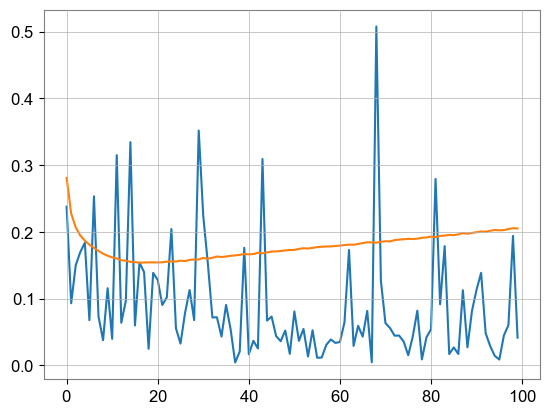

In [77]:
# 1

classifier = SupervisedModel().cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.BCEWithLogitsLoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_valid)))
    print(time.time() - t0)

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/SupLearn/ClassifierDNN.pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

In [100]:
# 2

classifier = SupervisedModel().cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.BCEWithLogitsLoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_valid)))
    print(time.time() - t0)

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/SupLearn/ClassifierDNN.pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

13921
Epoch: 0001, Training loss=0.654521, Validation loss=0.603973, valid accuracy=16.000000
4.273655652999878


KeyboardInterrupt: 

13921


Epoch: 0001, Training loss=0.585107, Validation loss=0.610425, valid accuracy=16.000000
4.346535682678223
Epoch: 0002, Training loss=0.517883, Validation loss=0.549428, valid accuracy=16.000000
4.302384853363037
Epoch: 0003, Training loss=0.439053, Validation loss=0.522449, valid accuracy=16.000000
4.276697874069214
Epoch: 0004, Training loss=0.530993, Validation loss=0.505342, valid accuracy=16.000000
4.250147581100464
Epoch: 0005, Training loss=0.514874, Validation loss=0.492506, valid accuracy=16.000000
4.2605602741241455
Epoch: 0006, Training loss=0.460916, Validation loss=0.483548, valid accuracy=16.000000
4.249680280685425
Epoch: 0007, Training loss=0.445171, Validation loss=0.476226, valid accuracy=16.000000
4.255950450897217
Epoch: 0008, Training loss=0.389020, Validation loss=0.470131, valid accuracy=16.000000
4.255450248718262
Epoch: 0009, Training loss=0.334187, Validation loss=0.465372, valid accuracy=16.000000
4.247083902359009
Epoch: 0010, Training loss=0.632717, Validati

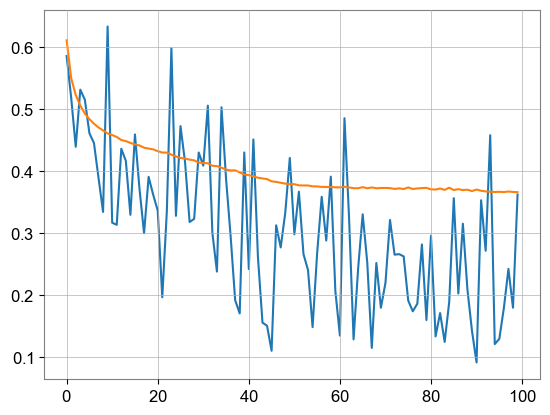

In [111]:
# 3

classifier = SupervisedModel().cuda()
print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.BCEWithLogitsLoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_valid)))
    print(time.time() - t0)

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

torch.save(classifier.cuda(), "../Model_cached/SupLearn/ClassifierDNN.pt")
# np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

In [113]:
classifier

SupervisedModel(
  (fc1): Linear(in_features=200, out_features=64, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

In [78]:
# 1
torch.save(classifier.cpu(),'../Model_cached/model_full_supervised_200-64-16-1_GWAK_bbhtrained.pt')

In [81]:
# 2
torch.save(classifier.cpu(),'../Model_cached/model_full_supervised_200-64-16-1_GWAK_sgtrained.pt')

In [124]:
# 3
torch.save(classifier.cpu(),'../Model_cached/model_full_supervised_200-64-16-1_GWAK_noisetrained_reversed.pt')

In [115]:
classifier = torch.load('../Model_cached/model_full_supervised_200-64-16-1_GWAK_bbhtrained.pt')

In [120]:
classifier = torch.load('../Model_cached/model_full_supervised_200-64-16-1_GWAK_sgtrained.pt')

In [130]:
classifier = torch.load('../Model_cached/model_full_supervised_200-64-16-1_GWAK_noisetrained_reversed.pt')

In [132]:
classifier = torch.load("../Model_cached/SupLearn/ClassifierDNN.pt")

In [87]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])) > 0.5
np.sum((prediction == test_dataset[:][1]).detach().numpy().flatten()) / len(test_dataset)

0.935525

In [93]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])) > 0.5
np.sum((prediction == test_dataset[:][1]).detach().numpy().flatten()) / len(test_dataset)

0.823425

In [97]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])) > 0.5
np.sum((prediction == test_dataset[:][1]).detach().numpy().flatten()) / len(test_dataset)

0.815175

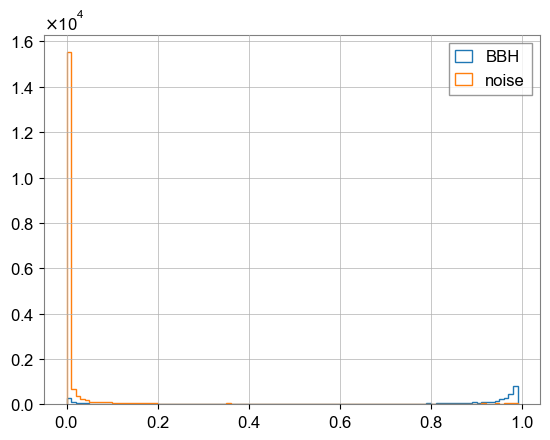

20000
20000


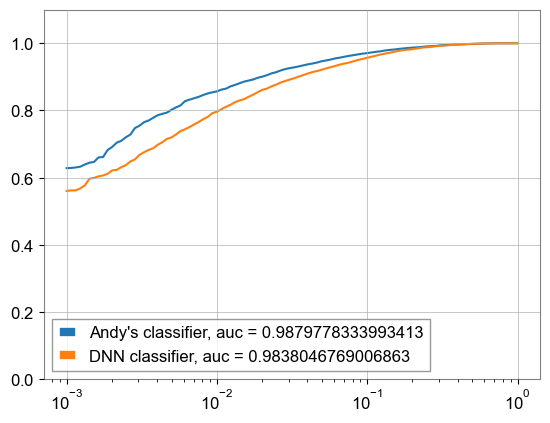

In [118]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])).detach().numpy()

bins = np.arange(0,1,0.01)

plt.hist(prediction[:nTest], histtype = 'step', bins = bins, label = 'BBH')
plt.hist(prediction[nTest:], histtype = 'step', bins = bins, label = 'noise')
plt.legend()
plt.show()

TPR_list = np.load('../Data_cached/ROC_BBH_AF.npy')[:,1]
plt.plot(FPR_list, TPR_list, label = 'Andy\'s classifier, auc = ' + str(auc(FPR_list, TPR_list)))

TPR_list = upperTPRFPRcalc(prediction[nTest:].flatten(), prediction[:nTest].flatten(), FPR_list)
plt.plot(FPR_list, TPR_list, label = 'DNN classifier, auc = ' + str(auc(FPR_list, TPR_list)))
plt.xscale('log')
plt.ylim(0,1.1)
plt.legend()
plt.show()

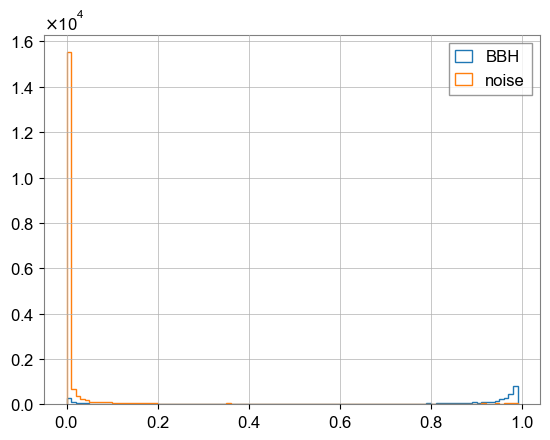

20000
20000


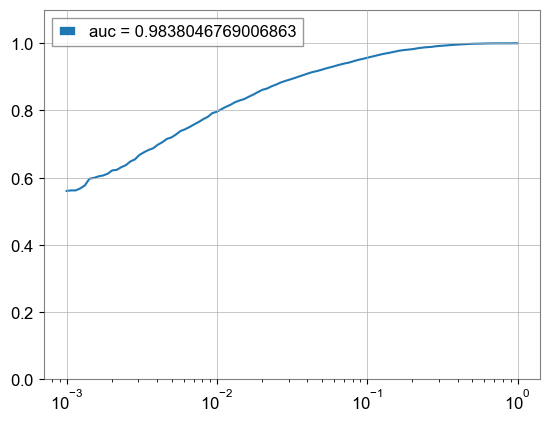

In [88]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])).detach().numpy()

bins = np.arange(0,1,0.01)

plt.hist(prediction[:nTest], histtype = 'step', bins = bins, label = 'BBH')
plt.hist(prediction[nTest:], histtype = 'step', bins = bins, label = 'noise')
plt.legend()
plt.show()

TPR_list = upperTPRFPRcalc(prediction[nTest:].flatten(), prediction[:nTest].flatten(), FPR_list)
plt.plot(FPR_list, TPR_list, label = 'auc = ' + str(auc(FPR_list, TPR_list)))
plt.xscale('log')
plt.ylim(0,1.1)
plt.legend()
plt.show()

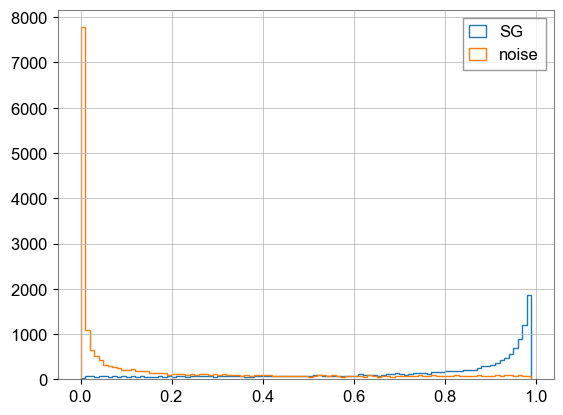

20000
20000


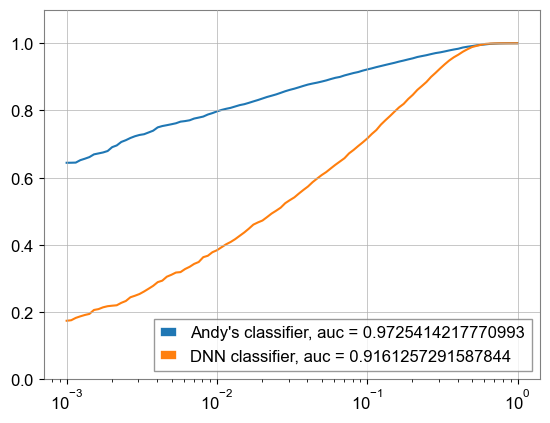

In [122]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])).detach().numpy()

bins = np.arange(0,1,0.01)

plt.hist(prediction[:nTest], histtype = 'step', bins = bins, label = 'SG')
plt.hist(prediction[nTest:], histtype = 'step', bins = bins, label = 'noise')
plt.legend()
plt.show()

TPR_list = np.load('../Data_cached/ROC_SG_AF.npy')[:,1]
plt.plot(FPR_list, TPR_list, label = 'Andy\'s classifier, auc = ' + str(auc(FPR_list, TPR_list)))

TPR_list = upperTPRFPRcalc(prediction[nTest:].flatten(), prediction[:nTest].flatten(), FPR_list)
plt.plot(FPR_list, TPR_list, label = 'DNN classifier, auc = ' + str(auc(FPR_list, TPR_list)))
plt.xscale('log')
plt.ylim(0,1.1)
plt.legend()
plt.show()

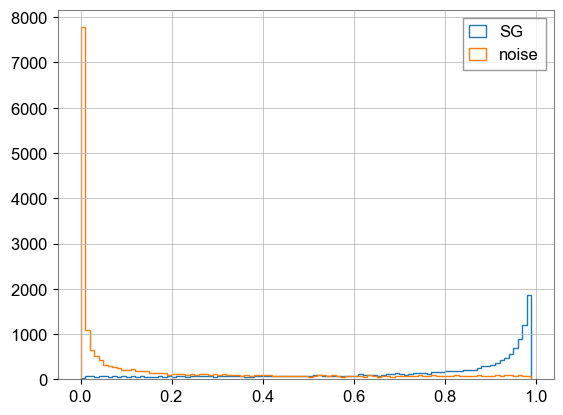

20000
20000


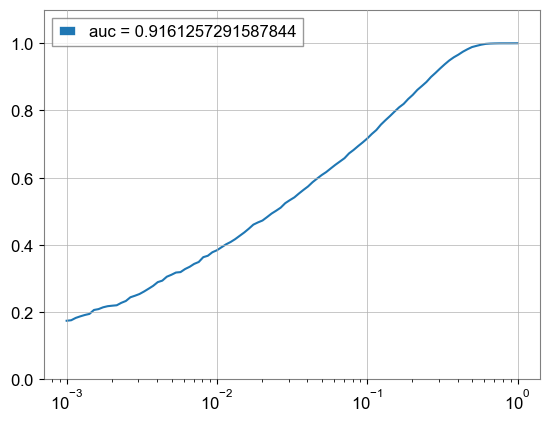

In [94]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])).detach().numpy()

bins = np.arange(0,1,0.01)

plt.hist(prediction[:nTest], histtype = 'step', bins = bins, label = 'SG')
plt.hist(prediction[nTest:], histtype = 'step', bins = bins, label = 'noise')
plt.legend()
plt.show()

TPR_list = upperTPRFPRcalc(prediction[nTest:].flatten(), prediction[:nTest].flatten(), FPR_list)
plt.plot(FPR_list, TPR_list, label = 'auc = ' + str(auc(FPR_list, TPR_list)))
plt.xscale('log')
plt.ylim(0,1.1)
plt.legend()
plt.show()

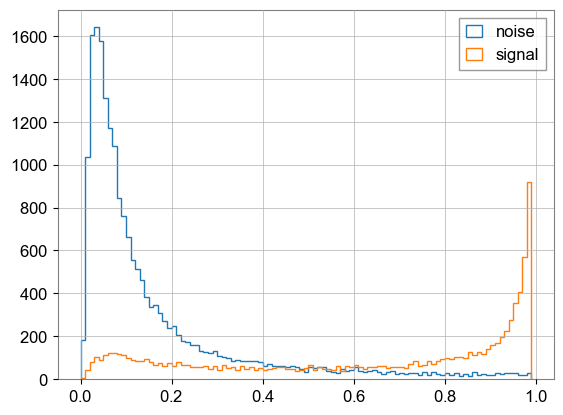

20000
20000


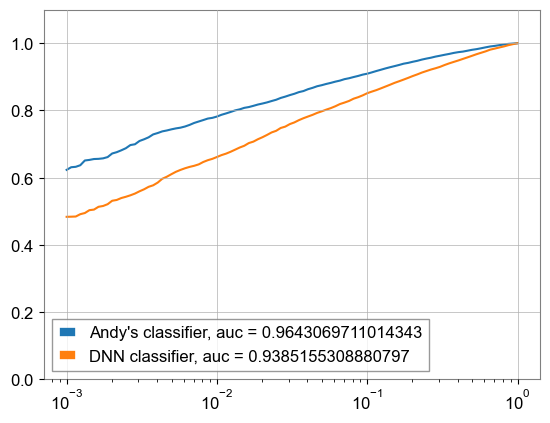

In [134]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])).detach().numpy()

bins = np.arange(0,1,0.01)

plt.hist(prediction[:nTest], histtype = 'step', bins = bins, label = 'noise')
plt.hist(prediction[nTest:], histtype = 'step', bins = bins, label = 'signal')
plt.legend()
plt.show()


TPR_list = np.load('../Data_cached/ROC_BKG_AF.npy')[:,1]
plt.plot(FPR_list, TPR_list, label = 'Andy\'s classifier, auc = ' + str(auc(FPR_list, TPR_list)))

TPR_list = upperTPRFPRcalc(prediction[:nTest].flatten(), prediction[nTest:].flatten(), FPR_list)
plt.plot(FPR_list, TPR_list, label = 'DNN classifier, auc = ' + str(auc(FPR_list, TPR_list)))
plt.xscale('log')
plt.ylim(0,1.1)
plt.legend()
plt.show()

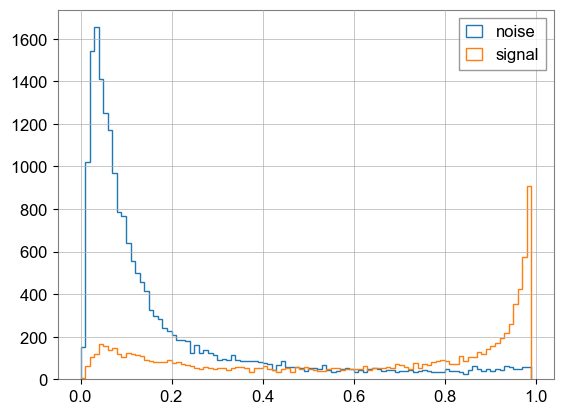

20000
20000


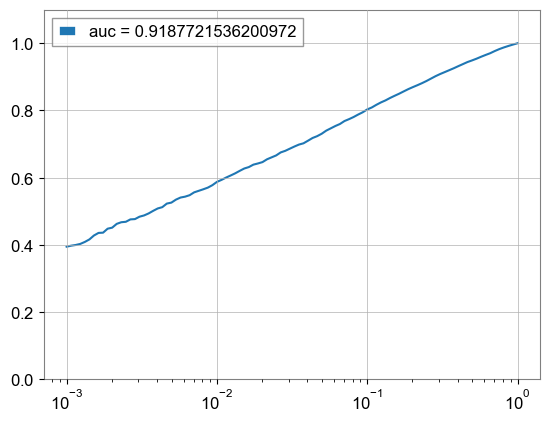

In [112]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])).detach().numpy()

bins = np.arange(0,1,0.01)

plt.hist(prediction[:nTest], histtype = 'step', bins = bins, label = 'noise')
plt.hist(prediction[nTest:], histtype = 'step', bins = bins, label = 'signal')
plt.legend()
plt.show()

TPR_list = upperTPRFPRcalc(prediction[:nTest].flatten(), prediction[nTest:].flatten(), FPR_list)
plt.plot(FPR_list, TPR_list, label = 'auc = ' + str(auc(FPR_list, TPR_list)))
plt.xscale('log')
plt.ylim(0,1.1)
plt.legend()
plt.show()

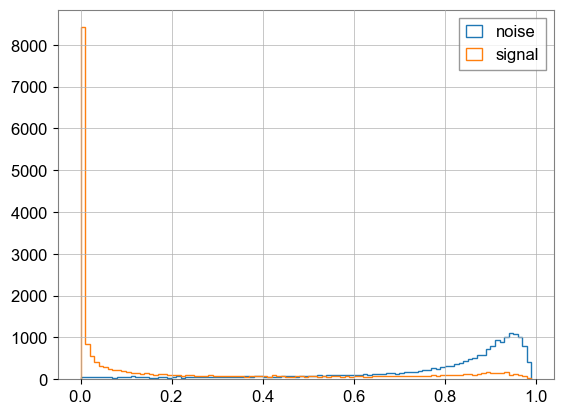

20000
20000


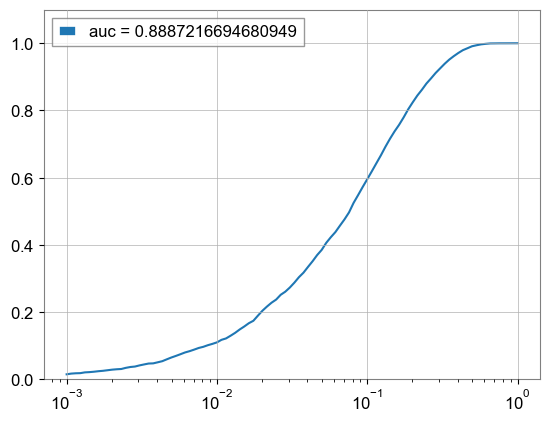

In [98]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])).detach().numpy()

bins = np.arange(0,1,0.01)

plt.hist(prediction[:nTest], histtype = 'step', bins = bins, label = 'noise')
plt.hist(prediction[nTest:], histtype = 'step', bins = bins, label = 'signal')
plt.legend()
plt.show()

TPR_list = upperTPRFPRcalc(prediction[nTest:].flatten(), prediction[:nTest].flatten(), FPR_list)
plt.plot(FPR_list, TPR_list, label = 'auc = ' + str(auc(FPR_list, TPR_list)))
plt.xscale('log')
plt.ylim(0,1.1)
plt.legend()
plt.show()

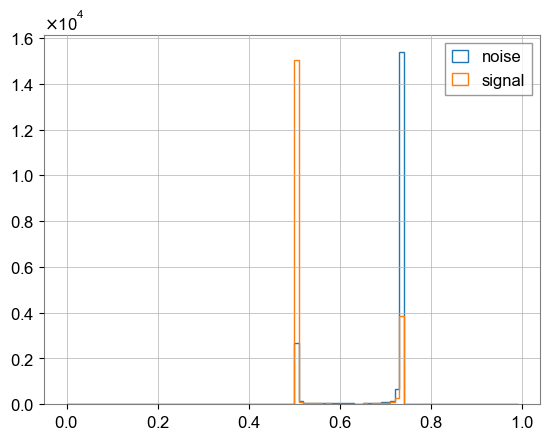

20000
20000


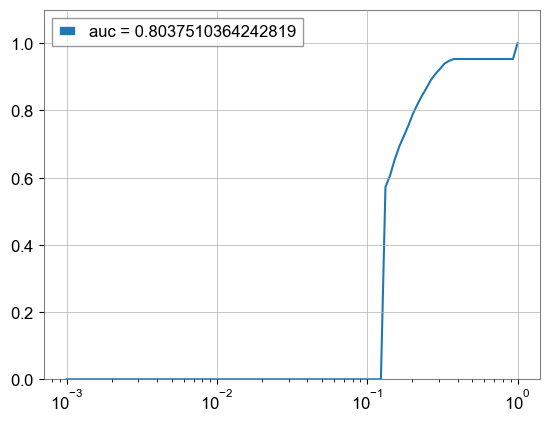

In [60]:
classifier.cpu().eval();
prediction = nn.Sigmoid()(classifier(test_dataset[:][0])).detach().numpy()

bins = np.arange(0,1,0.01)

plt.hist(prediction[:nTest], histtype = 'step', bins = bins, label = 'noise')
plt.hist(prediction[nTest:], histtype = 'step', bins = bins, label = 'signal')
plt.legend()
plt.show()

TPR_list = upperTPRFPRcalc(prediction[nTest:].flatten(), prediction[:nTest].flatten(), FPR_list)
plt.plot(FPR_list, TPR_list, label = 'auc = ' + str(auc(FPR_list, TPR_list)))
plt.xscale('log')
plt.ylim(0,1.1)
plt.legend()
plt.show()

In [137]:
autoencoder.cpu()

SupervisedModel(
  (fc1): Linear(in_features=200, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

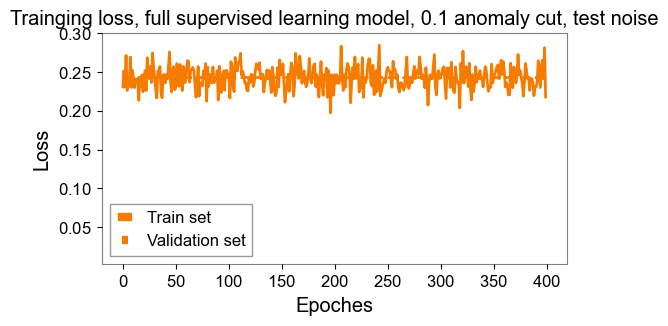

In [312]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, full supervised learning model, 0.1 anomaly cut, test noise')
plt.ylim(0.002,0.3)
plt.legend()
plt.show()

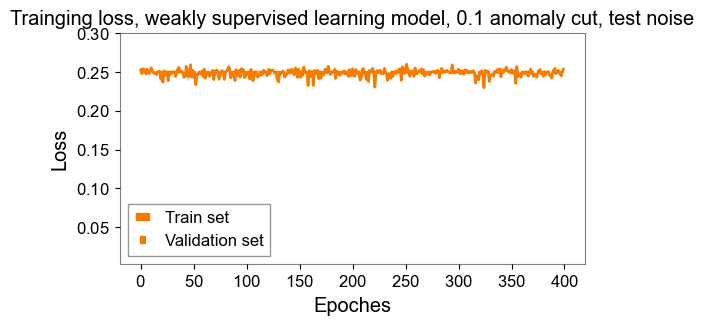

In [287]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, weakly supervised learning model, 0.1 anomaly cut, test noise')
plt.ylim(0.002,0.3)
plt.legend()
plt.show()

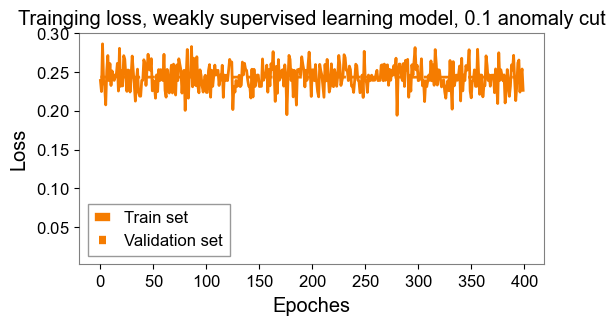

In [256]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, weakly supervised learning model, 0.1 anomaly cut')
plt.ylim(0.002,0.3)
plt.legend()
plt.show()

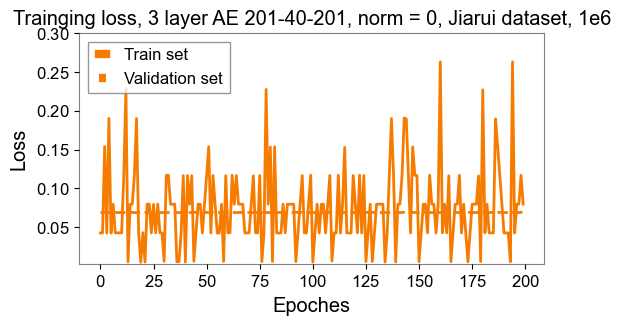

In [190]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 3 layer AE 201-40-201, norm = 0, Jiarui dataset, 1e6')
plt.ylim(0.002,0.3)
plt.legend()
plt.show()

### Bunch training

In [13]:
snr_list = np.arange(1,32,3)

In [14]:
for i in range(len(snr_list)):
    
    data_signal = np.vstack((data_signal_noise, data_signal_bbh[np.random.choice(len(data_signal_bbh), size = int(snr_list[i] * len(data_signal_noise)))]))
    data_bkg = data_train[np.random.choice(len(data_train),size = max(20000, len(data_signal)),  replace=False)]
    
    print(data_signal.shape)
    print(data_bkg.shape)
    
    data_signal_labeled = np.hstack((data_signal,np.ones(len(data_signal)).reshape(-1,1)))
    data_bkg_labeled = np.hstack((data_bkg,np.zeros(len(data_bkg)).reshape(-1,1)))
    
    Final_training_and_validation_set = np.vstack((data_signal_labeled, data_bkg_labeled))
    np.random.shuffle(Final_training_and_validation_set)

    trainData = torch.FloatTensor(Final_training_and_validation_set[:int(0.9 * len(Final_training_and_validation_set))])
    validationData = torch.FloatTensor(Final_training_and_validation_set[int(0.9 * len(Final_training_and_validation_set)):])
    train_dataset = TensorDataset(trainData, trainData)
    validation_dataset = TensorDataset(validationData, validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)


    autoencoder = SupervisedModel().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.BCEWithLogitsLoss().cuda()
    loss_train = np.zeros((epochs, 1))
    loss_validation = np.zeros((epochs, 1))


    for epoch in range(epochs):
        # 训练阶段
        autoencoder.train()
        for batchidx, (x, _) in enumerate(trainDataLoader):
            x = x.cuda()
            decoded = autoencoder(x[:,:200])
            # weighted_lossTrain = loss_func(decoded, x)
            loss_overall = loss_func(decoded.flatten(), x[:,-1])
            # loss_norm = loss_func(decoded[:, -1], x[:, -1])
            
            weighted_lossTrain = loss_overall
            # weighted_lossTrain = loss_overall + loss_norm * coef_delta
            
            # output_norm = torch.norm(decoded[:, :100], dim=1) 
            # penalty_term = torch.mean((output_norm - 1) ** 2) 
            # weighted_lossTrain = lossTrain + coef_delta * penalty_term
            
            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()

        # 验证阶段
        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, _) in enumerate(validationDataLoader):
                x = x.cuda()
                decoded = autoencoder(x[:,:200])
                lossVal_overall = loss_func(decoded.flatten(), x[:,-1])
                lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
                lossVal = lossVal_overall + lossVal_norm * coef_delta
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)
        
        loss_train[epoch,0] = weighted_lossTrain.item()
        loss_validation[epoch,0] = val_loss
        # print('Epoch: %04d, Training loss=%.8f' % (epoch+1, weighted_lossTrain.item()))
        print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))
        
    torch.save(autoencoder.cpu(),'../Model_cached/model_full_supervised_200-64-32-1_GWAK_snr'+str(snr_list[i])+'.pt')
    
    
    fig = plt.figure(figsize=(6, 3))
    ax = plt.subplot(1, 1, 1)
    ax.grid()
    ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
    ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
    ax.set_xlabel('Epoches')
    ax.set_ylabel('Loss')
    ax.set_title('Trainging loss, weakly supervised learning model, 0.1 anomaly cut, test noise with glitches, snr' +str(snr_list[i]))
    plt.ylim(0.002,0.3)
    plt.legend()
    # plt.show()
    plt.save('../Pic_cached/Trainging loss, weakly supervised learning model, 0.1 anomaly cut, test noise with glitches, snr'+str(snr_list[i]))

(4002, 200)
(20000, 200)
Epoch: 0001, Training loss=0.07394630, Validation loss=0.13304758
Epoch: 0002, Training loss=0.02963773, Validation loss=0.12446487
Epoch: 0003, Training loss=0.00591716, Validation loss=0.11602645
Epoch: 0004, Training loss=0.01647881, Validation loss=0.10971925
Epoch: 0005, Training loss=0.65616202, Validation loss=0.10589400
Epoch: 0006, Training loss=0.00688022, Validation loss=0.10399859
Epoch: 0007, Training loss=0.02738989, Validation loss=0.10264240
Epoch: 0008, Training loss=0.50508845, Validation loss=0.10238258
Epoch: 0009, Training loss=0.64822125, Validation loss=0.10096879
Epoch: 0010, Training loss=0.01251101, Validation loss=0.10083964
Epoch: 0011, Training loss=0.00192534, Validation loss=0.11200374
Epoch: 0012, Training loss=0.00461093, Validation loss=0.09935817
Epoch: 0013, Training loss=0.00000000, Validation loss=0.10496077
Epoch: 0014, Training loss=0.01169573, Validation loss=0.09871823
Epoch: 0015, Training loss=0.00000000, Validation l

KeyboardInterrupt: 

In [114]:
snr_list

array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31])

(46069, 200)
(46069, 200)
Epoch: 0001, Training loss=0.64241117, Validation loss=0.65979868
Epoch: 0002, Training loss=0.64045358, Validation loss=0.57201585
Epoch: 0003, Training loss=0.56666464, Validation loss=0.45512685
Epoch: 0004, Training loss=0.26927561, Validation loss=0.38089686
Epoch: 0005, Training loss=0.27232754, Validation loss=0.34031784
Epoch: 0006, Training loss=0.47184074, Validation loss=0.31609121
Epoch: 0007, Training loss=0.32786384, Validation loss=0.29976173
Epoch: 0008, Training loss=0.11863851, Validation loss=0.28750574
Epoch: 0009, Training loss=0.12091023, Validation loss=0.27764721
Epoch: 0010, Training loss=0.17387146, Validation loss=0.27087345
Epoch: 0011, Training loss=0.50554049, Validation loss=0.26599791
Epoch: 0012, Training loss=0.09677719, Validation loss=0.26089944
Epoch: 0013, Training loss=0.14527886, Validation loss=0.25560215
Epoch: 0014, Training loss=0.16063324, Validation loss=0.25313844
Epoch: 0015, Training loss=0.20642209, Validation 

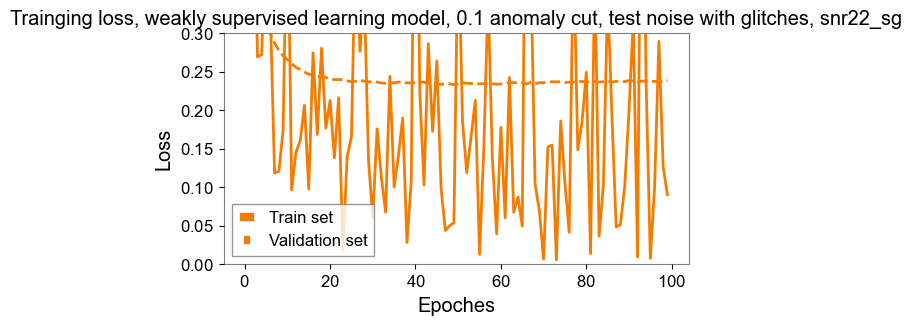

In [142]:
for i in [7]:
    
    data_signal = np.vstack((data_signal_noise, data_signal_bbh[np.random.choice(len(data_signal_bbh), size = int(snr_list[i] * len(data_signal_noise)), replace=False)]))
    data_bkg = data_train[np.random.choice(len(data_train),size = max(20000, len(data_signal)),  replace=False)]
    
    print(data_signal.shape)
    print(data_bkg.shape)
    
    data_signal_labeled = np.hstack((data_signal,np.ones(len(data_signal)).reshape(-1,1)))
    data_bkg_labeled = np.hstack((data_bkg,np.zeros(len(data_bkg)).reshape(-1,1)))
    
    Final_training_and_validation_set = np.vstack((data_signal_labeled, data_bkg_labeled))
    np.random.shuffle(Final_training_and_validation_set)

    trainData = torch.FloatTensor(Final_training_and_validation_set[:int(0.9 * len(Final_training_and_validation_set))])
    validationData = torch.FloatTensor(Final_training_and_validation_set[int(0.9 * len(Final_training_and_validation_set)):])
    train_dataset = TensorDataset(trainData, trainData)
    validation_dataset = TensorDataset(validationData, validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)


    autoencoder = SupervisedModel().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.BCELoss().cuda()
    loss_train = np.zeros((epochs, 1))
    loss_validation = np.zeros((epochs, 1))


    for epoch in range(epochs):
        # 训练阶段
        autoencoder.train()
        for batchidx, (x, _) in enumerate(trainDataLoader):
            x = x.cuda()
            decoded = autoencoder(x[:,:200])
            # weighted_lossTrain = loss_func(decoded, x)
            loss_overall = loss_func(decoded.flatten(), x[:,-1])
            # loss_norm = loss_func(decoded[:, -1], x[:, -1])
            
            weighted_lossTrain = loss_overall
            # weighted_lossTrain = loss_overall + loss_norm * coef_delta
            
            # output_norm = torch.norm(decoded[:, :100], dim=1) 
            # penalty_term = torch.mean((output_norm - 1) ** 2) 
            # weighted_lossTrain = lossTrain + coef_delta * penalty_term
            
            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()

        # 验证阶段
        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, _) in enumerate(validationDataLoader):
                x = x.cuda()
                decoded = autoencoder(x[:,:200])
                lossVal_overall = loss_func(decoded.flatten(), x[:,-1])
                lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
                lossVal = lossVal_overall + lossVal_norm * coef_delta
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)
        
        loss_train[epoch,0] = weighted_lossTrain.item()
        loss_validation[epoch,0] = val_loss
        # print('Epoch: %04d, Training loss=%.8f' % (epoch+1, weighted_lossTrain.item()))
        print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))
        
    torch.save(autoencoder.cpu(),'../Model_cached/model_semi_supervised_200-32-16-1_GWAK_snr'+str(snr_list[i])+'_sg_new_100.pt')
    
    
    fig = plt.figure(figsize=(6, 3))
    ax = plt.subplot(1, 1, 1)
    ax.grid()
    ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
    ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
    ax.set_xlabel('Epoches')
    ax.set_ylabel('Loss')
    ax.set_title('Trainging loss, weakly supervised learning model, 0.1 anomaly cut, test noise with glitches, snr' +str(snr_list[i]) + '_sg')
    plt.ylim(0,0.3)
    plt.legend()
    # plt.show()
    plt.savefig('../Pic_cached/Trainging loss, weakly supervised learning model, 200-32-16-1, 0.1 anomaly cut, test noise with glitches, snr'+str(snr_list[i])+'_sg_new_100.png')

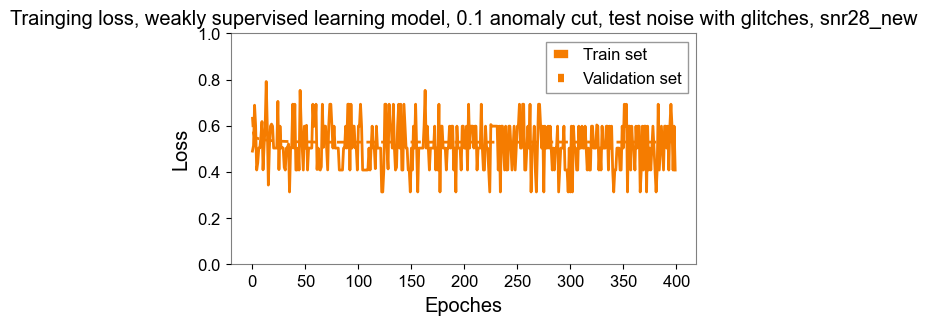

In [53]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, weakly supervised learning model, 0.1 anomaly cut, test noise with glitches, snr' +str(snr_list[i]) + '_new')
plt.ylim(0,1)
plt.legend()
plt.show()

In [141]:
decodedTestdata = autoencoder(trainData[:,:200])
decodedTestdata = decodedTestdata.double()
reconstructedData_train = decodedTestdata.detach().numpy()
ReconstructedError_train = (trainData[:,-1].numpy() - reconstructedData_train.reshape(-1))**2
MSE_train = ReconstructedError_train.mean()

In [142]:
decodedTestdata = autoencoder(testData[:,:200])
decodedTestdata = decodedTestdata.double()
reconstructedData_test = decodedTestdata.detach().numpy()
ReconstructedError_test = (testData[:,-1].numpy() - reconstructedData_test.reshape(-1))**2
MSE_test = ReconstructedError_test.mean()

In [135]:
signalbbhData = torch.FloatTensor(data_bbh_normalized[np.setdiff1d(np.arange(len(data_bbh_normalized)), selected_bbh_indices)])

In [143]:
decodedTestdata = autoencoder(signalbbhData[:,:200])
decodedTestdata = decodedTestdata.double()
reconstructedData_signalbbhData = decodedTestdata.detach().numpy()
ReconstructedError_signalbbhData = (signalbbhData[:,-1].numpy() - reconstructedData_signalbbhData.reshape(-1))**2
MSE_signalbbhData = ReconstructedError_signalbbhData.mean()

In [313]:
bkgData = torch.FloatTensor(data_noise_normalized[-test_size:])
bbhData = torch.FloatTensor(data_bbh_normalized[random_indices_complementary])

In [337]:
bkgData = torch.FloatTensor(data_noise_normalized[-test_size:])
bbhData = torch.FloatTensor(data_bbh_normalized)

In [314]:
bkgData.shape

torch.Size([20000, 200])

In [342]:
decodedTestdata = autoencoder(bkgData)
decodedTestdata = decodedTestdata.double()
anomaly_score_bkg = decodedTestdata.detach().numpy()

In [343]:
decodedTestdata = autoencoder(bbhData)
decodedTestdata = decodedTestdata.double()
anomaly_score_bbh = decodedTestdata.detach().numpy()

In [89]:
autoencoder = torch.load('../Model_cached/model_semi_supervised_200-32-16-1_GWAK_snr31_new_new.pt')
bkgData = torch.FloatTensor(data_full_noise)
bbhData = torch.FloatTensor(data_full_bbh)

decodedTestdata = autoencoder(bkgData)
decodedTestdata = decodedTestdata.double()
anomaly_score_bkg = decodedTestdata.detach().numpy()

decodedTestdata = autoencoder(bbhData)
decodedTestdata = decodedTestdata.double()
anomaly_score_bbh = decodedTestdata.detach().numpy()


In [175]:
autoencoder = torch.load('../Model_cached/model_semi_supervised_200-32-16-1_GWAK_snr22_sg_new.pt')
bkgData = torch.FloatTensor(data_full_noise)
sgData = torch.FloatTensor(data_full_bbh)

decodedTestdata = autoencoder(bkgData)
decodedTestdata = decodedTestdata.double()
anomaly_score_bkg = decodedTestdata.detach().numpy()

decodedTestdata = autoencoder(sgData)
decodedTestdata = decodedTestdata.double()
anomaly_score_bbh = decodedTestdata.detach().numpy()


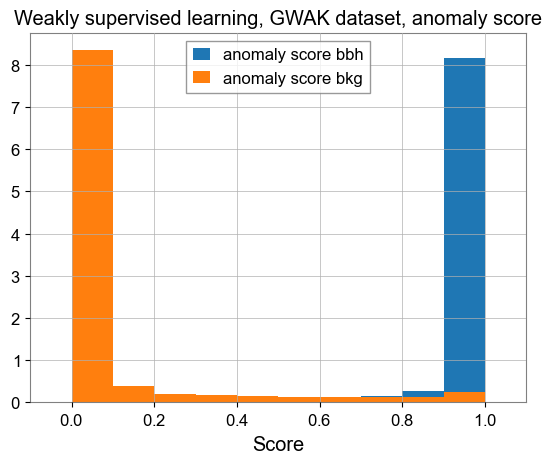

In [122]:
plt.hist(anomaly_score_bbh, density = True, label = 'anomaly score bbh')
plt.hist(anomaly_score_bkg, density = True, label = 'anomaly score bkg')

plt.xlim(-0.1, 1.1)
plt.xlabel('Score')
plt.title('Weakly supervised learning, GWAK dataset, anomaly score')
plt.legend()
plt.show()

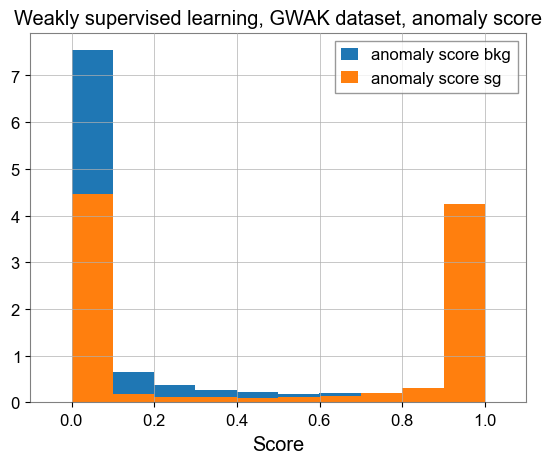

In [144]:
plt.hist(anomaly_score_bkg, density = True, label = 'anomaly score bkg')
plt.hist(anomaly_score_bbh, density = True, label = 'anomaly score sg')


plt.xlim(-0.1, 1.1)
plt.xlabel('Score')
plt.title('Weakly supervised learning, GWAK dataset, anomaly score')
plt.legend()
plt.show()

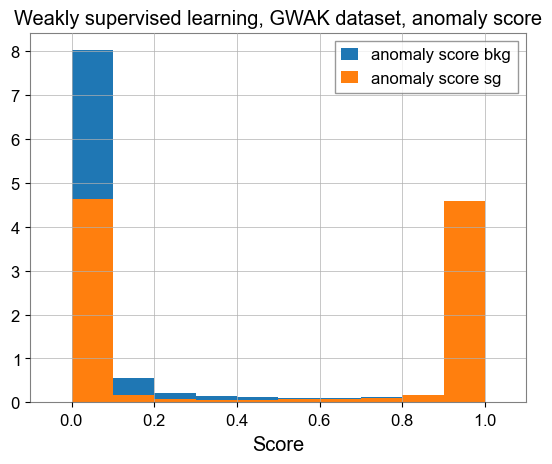

In [134]:
plt.hist(anomaly_score_bkg, density = True, label = 'anomaly score bkg')
plt.hist(anomaly_score_bbh, density = True, label = 'anomaly score sg')


plt.xlim(-0.1, 1.1)
plt.xlabel('Score')
plt.title('Weakly supervised learning, GWAK dataset, anomaly score')
plt.legend()
plt.show()

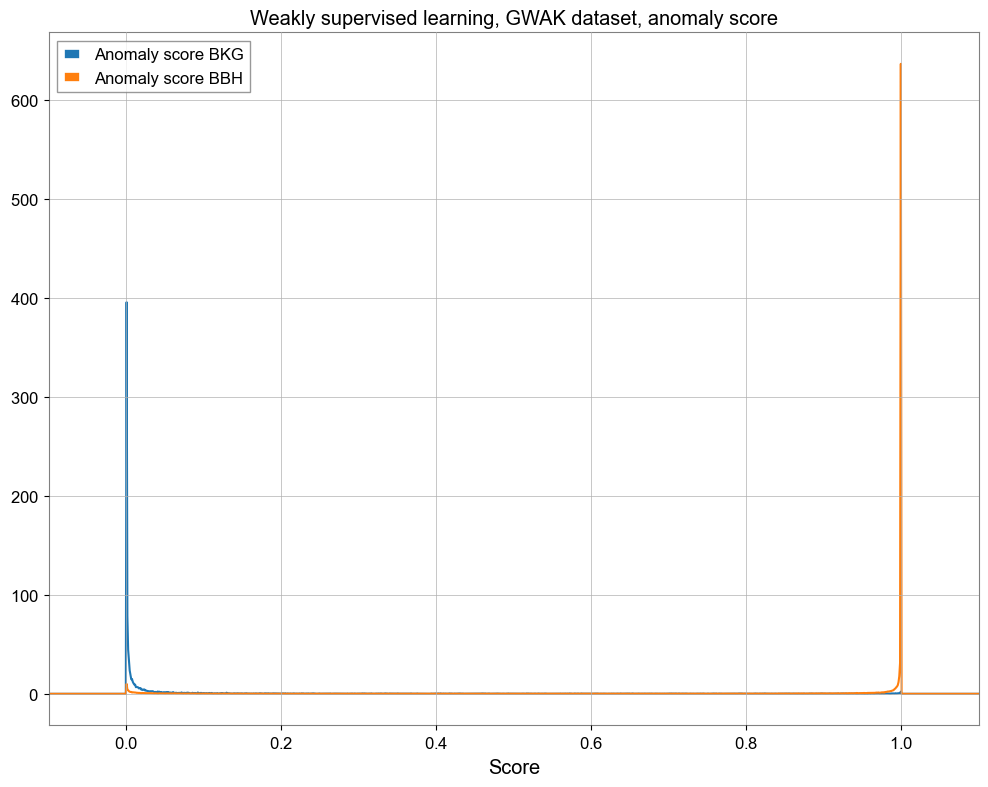

In [119]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.arange(-0.1, 1.1, 1e-3)

counts_train, bin_position_train = np.histogram(anomaly_score_bkg, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(anomaly_score_bbh, bins = bin_scheme, density = True)
# counts_signal, bin_position_signal = np.histogram(ReconstructedError_signalbbhData, bins = bin_scheme, density = True)
# counts_train_cut, bin_position_train_cut = np.histogram(ReconstructedError_train_cut_output_200d, bins = bin_scheme, density = True)

# counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_100d, bins = bin_scheme, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_100d, bins = bin_scheme, density = True)
# counts_glitches_real, bin_position_glitches_real = np.histogram(ReconstructedError_glitches_real_output_100d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
# bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_train_cut = (bin_position_train_cut[:-1] + bin_position_train_cut[1:]) / 2

# bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2
# bin_centers_glitches_real = (bin_position_glitches_real[:-1] + bin_position_glitches_real[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Anomaly score BKG')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Anomaly score BBH')
# plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_train_cut, counts_train_cut, color = colors[3], label = 'Training sample first 5e3')

# plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - simulated glitches')
# plt.plot(bin_centers_glitches_real, counts_glitches_real, color = colors[5], label = 'Signal sample - real glitches')


# plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
# plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
# plt.axvline(x = MSE_signalbbhData, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_train_cut_output_200d, color = colors[3], linestyle = '--', label = 'Training sample MSE first 5e3')

# plt.axvline(x = MSE_sinegaussian_output_100d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - simulated glitches')
# plt.axvline(x = MSE_glitches_real_output_100d, color = colors[5], linestyle = '--', label = 'Signal sample MSE - real glitches')


plt.xlim(-0.1, 1.1)
plt.xlabel('Score')
plt.title('Weakly supervised learning, GWAK dataset, anomaly score')
plt.legend()
plt.show()

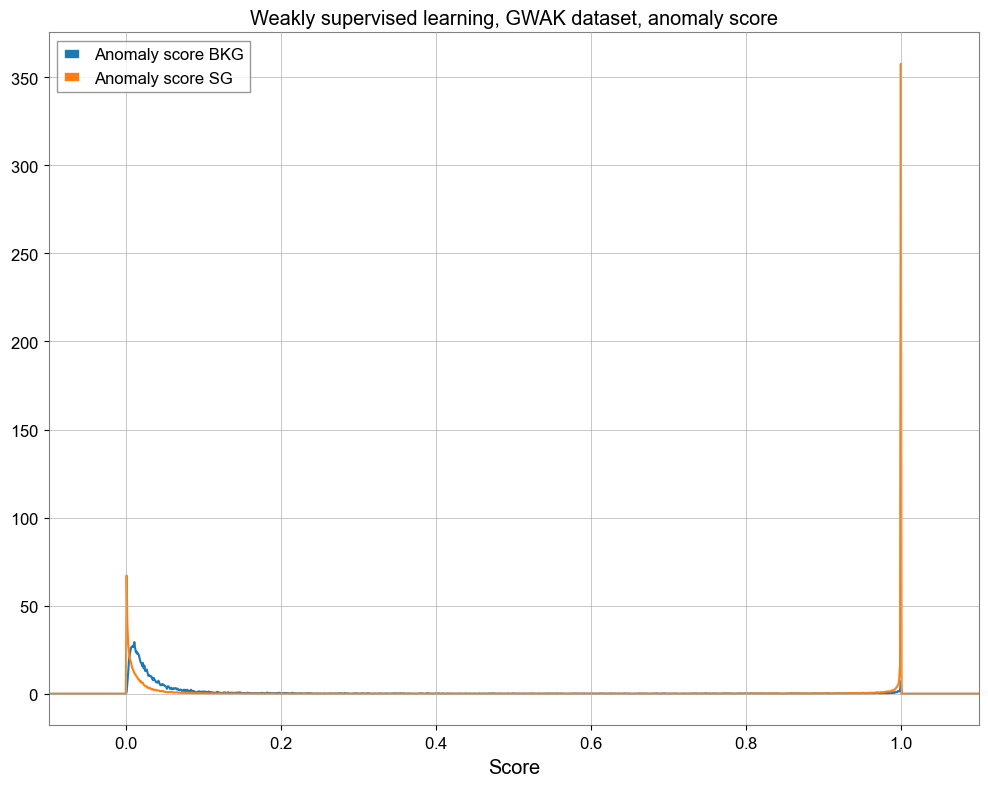

In [138]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.arange(-0.1, 1.1, 1e-3)

counts_train, bin_position_train = np.histogram(anomaly_score_bkg, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(anomaly_score_bbh, bins = bin_scheme, density = True)
# counts_signal, bin_position_signal = np.histogram(ReconstructedError_signalbbhData, bins = bin_scheme, density = True)
# counts_train_cut, bin_position_train_cut = np.histogram(ReconstructedError_train_cut_output_200d, bins = bin_scheme, density = True)

# counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_100d, bins = bin_scheme, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_100d, bins = bin_scheme, density = True)
# counts_glitches_real, bin_position_glitches_real = np.histogram(ReconstructedError_glitches_real_output_100d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
# bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_train_cut = (bin_position_train_cut[:-1] + bin_position_train_cut[1:]) / 2

# bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2
# bin_centers_glitches_real = (bin_position_glitches_real[:-1] + bin_position_glitches_real[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Anomaly score BKG')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Anomaly score SG')
# plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_train_cut, counts_train_cut, color = colors[3], label = 'Training sample first 5e3')

# plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - simulated glitches')
# plt.plot(bin_centers_glitches_real, counts_glitches_real, color = colors[5], label = 'Signal sample - real glitches')


# plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
# plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
# plt.axvline(x = MSE_signalbbhData, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_train_cut_output_200d, color = colors[3], linestyle = '--', label = 'Training sample MSE first 5e3')

# plt.axvline(x = MSE_sinegaussian_output_100d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - simulated glitches')
# plt.axvline(x = MSE_glitches_real_output_100d, color = colors[5], linestyle = '--', label = 'Signal sample MSE - real glitches')


plt.xlim(-0.1, 1.1)
plt.xlabel('Score')
plt.title('Weakly supervised learning, GWAK dataset, anomaly score')
plt.legend()
plt.show()

In [120]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.arange(0, 1, 1e-3)

counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_signalbbhData, bins = bin_scheme, density = True)
# counts_train_cut, bin_position_train_cut = np.histogram(ReconstructedError_train_cut_output_200d, bins = bin_scheme, density = True)

# counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_100d, bins = bin_scheme, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_100d, bins = bin_scheme, density = True)
# counts_glitches_real, bin_position_glitches_real = np.histogram(ReconstructedError_glitches_real_output_100d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_train_cut = (bin_position_train_cut[:-1] + bin_position_train_cut[1:]) / 2

# bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2
# bin_centers_glitches_real = (bin_position_glitches_real[:-1] + bin_position_glitches_real[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_train_cut, counts_train_cut, color = colors[3], label = 'Training sample first 5e3')

# plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - simulated glitches')
# plt.plot(bin_centers_glitches_real, counts_glitches_real, color = colors[5], label = 'Signal sample - real glitches')


plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_signalbbhData, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_train_cut_output_200d, color = colors[3], linestyle = '--', label = 'Training sample MSE first 5e3')

# plt.axvline(x = MSE_sinegaussian_output_100d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - simulated glitches')
# plt.axvline(x = MSE_glitches_real_output_100d, color = colors[5], linestyle = '--', label = 'Signal sample MSE - real glitches')


plt.xlim(0, 1)
plt.xlabel('Error')
plt.title('Normalized error distribution for 3 datasets, layer structure 201-40-201, norm factor = 100, pattern error, GWAK noise + pure BBH')
plt.legend()
plt.show()

NameError: name 'ReconstructedError_train' is not defined

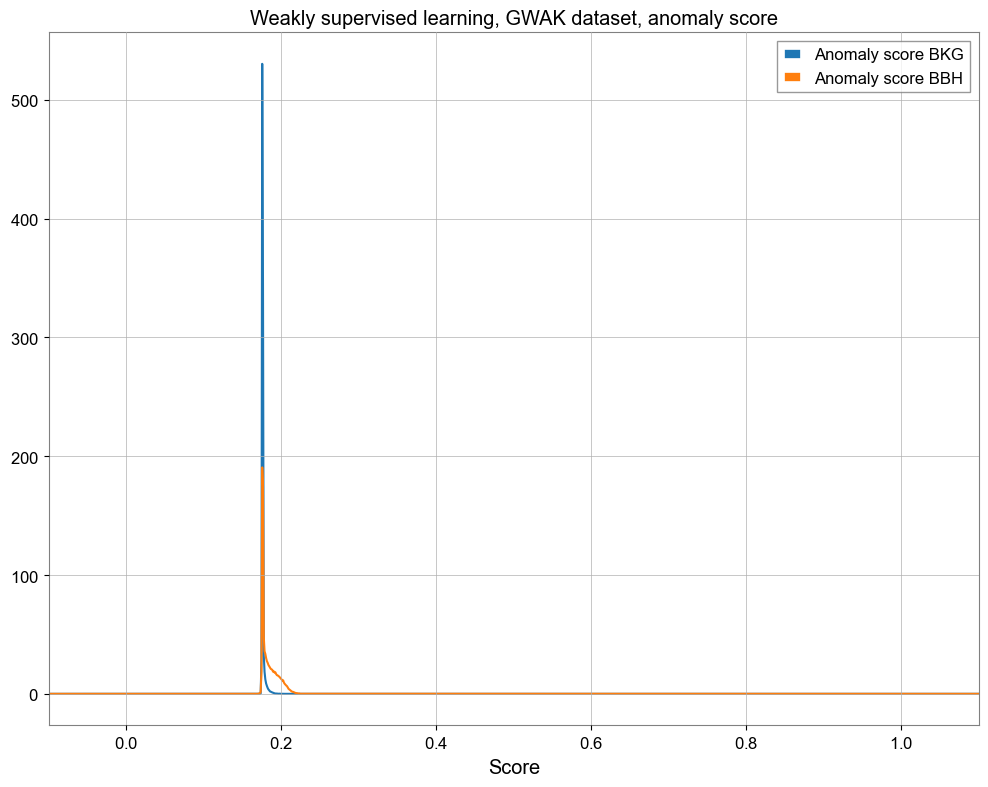

In [238]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.arange(-0.1, 1.1, 1e-3)

counts_train, bin_position_train = np.histogram(anomaly_score_bkg, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(anomaly_score_bbh, bins = bin_scheme, density = True)
# counts_signal, bin_position_signal = np.histogram(ReconstructedError_signalbbhData, bins = bin_scheme, density = True)
# counts_train_cut, bin_position_train_cut = np.histogram(ReconstructedError_train_cut_output_200d, bins = bin_scheme, density = True)

# counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_100d, bins = bin_scheme, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_100d, bins = bin_scheme, density = True)
# counts_glitches_real, bin_position_glitches_real = np.histogram(ReconstructedError_glitches_real_output_100d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
# bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_train_cut = (bin_position_train_cut[:-1] + bin_position_train_cut[1:]) / 2

# bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2
# bin_centers_glitches_real = (bin_position_glitches_real[:-1] + bin_position_glitches_real[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Anomaly score BKG')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Anomaly score BBH')
# plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_train_cut, counts_train_cut, color = colors[3], label = 'Training sample first 5e3')

# plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - simulated glitches')
# plt.plot(bin_centers_glitches_real, counts_glitches_real, color = colors[5], label = 'Signal sample - real glitches')


# plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
# plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
# plt.axvline(x = MSE_signalbbhData, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_train_cut_output_200d, color = colors[3], linestyle = '--', label = 'Training sample MSE first 5e3')

# plt.axvline(x = MSE_sinegaussian_output_100d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - simulated glitches')
# plt.axvline(x = MSE_glitches_real_output_100d, color = colors[5], linestyle = '--', label = 'Signal sample MSE - real glitches')


plt.xlim(-0.1, 1.1)
plt.xlabel('Score')
plt.title('Weakly supervised learning, GWAK dataset, anomaly score')
plt.legend()
plt.show()

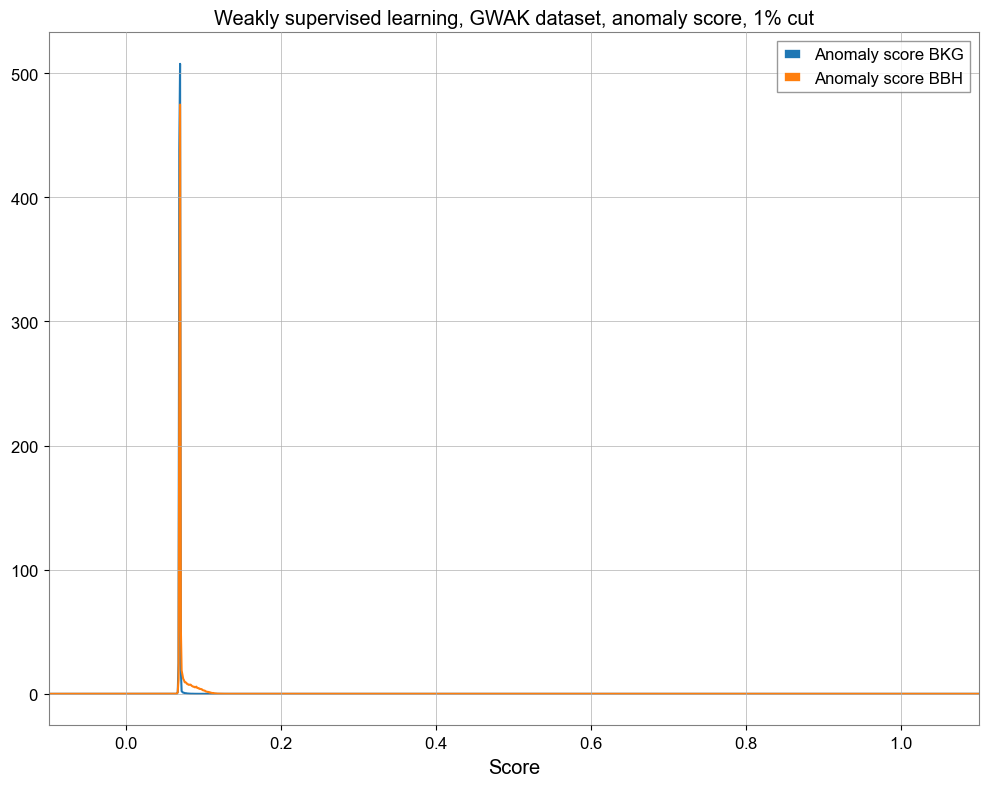

In [235]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.arange(-0.1, 1.1, 1e-3)

counts_train, bin_position_train = np.histogram(anomaly_score_bkg, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(anomaly_score_bbh, bins = bin_scheme, density = True)
# counts_signal, bin_position_signal = np.histogram(ReconstructedError_signalbbhData, bins = bin_scheme, density = True)
# counts_train_cut, bin_position_train_cut = np.histogram(ReconstructedError_train_cut_output_200d, bins = bin_scheme, density = True)

# counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_100d, bins = bin_scheme, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_100d, bins = bin_scheme, density = True)
# counts_glitches_real, bin_position_glitches_real = np.histogram(ReconstructedError_glitches_real_output_100d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
# bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_train_cut = (bin_position_train_cut[:-1] + bin_position_train_cut[1:]) / 2

# bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2
# bin_centers_glitches_real = (bin_position_glitches_real[:-1] + bin_position_glitches_real[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Anomaly score BKG')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Anomaly score BBH')
# plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_train_cut, counts_train_cut, color = colors[3], label = 'Training sample first 5e3')

# plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - simulated glitches')
# plt.plot(bin_centers_glitches_real, counts_glitches_real, color = colors[5], label = 'Signal sample - real glitches')


# plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
# plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
# plt.axvline(x = MSE_signalbbhData, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_train_cut_output_200d, color = colors[3], linestyle = '--', label = 'Training sample MSE first 5e3')

# plt.axvline(x = MSE_sinegaussian_output_100d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - simulated glitches')
# plt.axvline(x = MSE_glitches_real_output_100d, color = colors[5], linestyle = '--', label = 'Signal sample MSE - real glitches')


plt.xlim(-0.1, 1.1)
plt.xlabel('Score')
plt.title('Weakly supervised learning, GWAK dataset, anomaly score, 1% cut')
plt.legend()
plt.show()

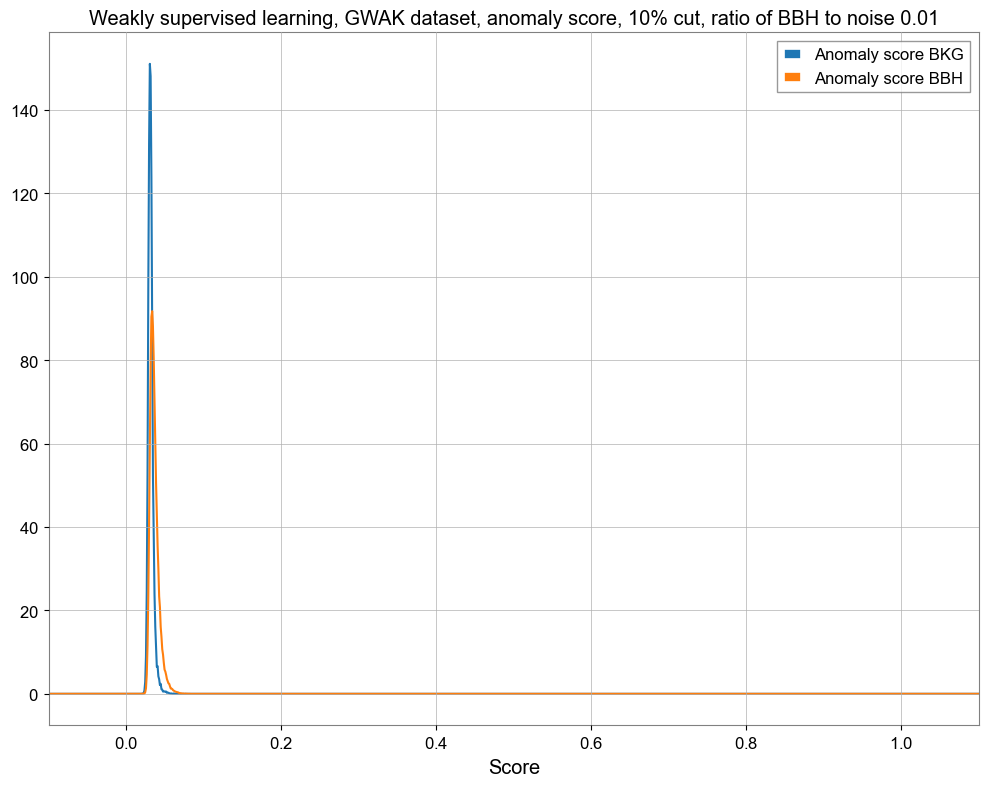

In [344]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.arange(-0.1, 1.1, 1e-3)

counts_train, bin_position_train = np.histogram(anomaly_score_bkg, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(anomaly_score_bbh, bins = bin_scheme, density = True)
# counts_signal, bin_position_signal = np.histogram(ReconstructedError_signalbbhData, bins = bin_scheme, density = True)
# counts_train_cut, bin_position_train_cut = np.histogram(ReconstructedError_train_cut_output_200d, bins = bin_scheme, density = True)

# counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_100d, bins = bin_scheme, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_100d, bins = bin_scheme, density = True)
# counts_glitches_real, bin_position_glitches_real = np.histogram(ReconstructedError_glitches_real_output_100d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
# bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_train_cut = (bin_position_train_cut[:-1] + bin_position_train_cut[1:]) / 2

# bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2
# bin_centers_glitches_real = (bin_position_glitches_real[:-1] + bin_position_glitches_real[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Anomaly score BKG')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Anomaly score BBH')
# plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_train_cut, counts_train_cut, color = colors[3], label = 'Training sample first 5e3')

# plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - simulated glitches')
# plt.plot(bin_centers_glitches_real, counts_glitches_real, color = colors[5], label = 'Signal sample - real glitches')


# plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
# plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
# plt.axvline(x = MSE_signalbbhData, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_train_cut_output_200d, color = colors[3], linestyle = '--', label = 'Training sample MSE first 5e3')

# plt.axvline(x = MSE_sinegaussian_output_100d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - simulated glitches')
# plt.axvline(x = MSE_glitches_real_output_100d, color = colors[5], linestyle = '--', label = 'Signal sample MSE - real glitches')


plt.xlim(-0.1, 1.1)
plt.xlabel('Score')
plt.title('Weakly supervised learning, GWAK dataset, anomaly score, 10% cut, ratio of BBH to noise 0.01')
plt.legend()
plt.show()

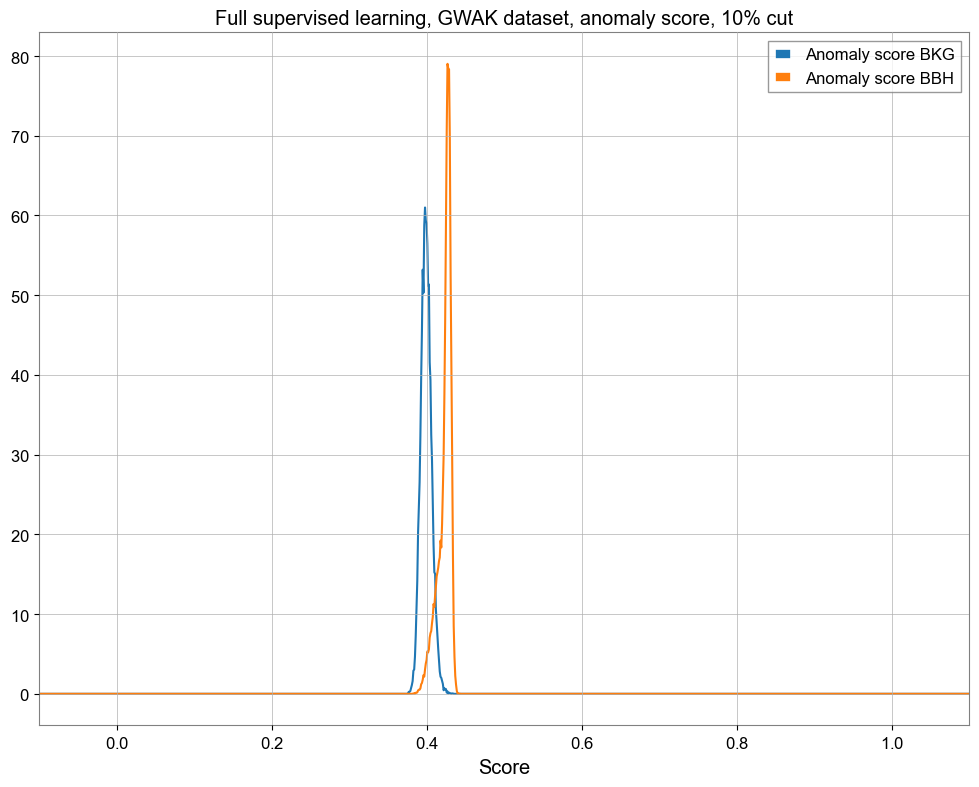

In [317]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.arange(-0.1, 1.1, 1e-3)

counts_train, bin_position_train = np.histogram(anomaly_score_bkg, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(anomaly_score_bbh, bins = bin_scheme, density = True)
# counts_signal, bin_position_signal = np.histogram(ReconstructedError_signalbbhData, bins = bin_scheme, density = True)
# counts_train_cut, bin_position_train_cut = np.histogram(ReconstructedError_train_cut_output_200d, bins = bin_scheme, density = True)

# counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_100d, bins = bin_scheme, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_100d, bins = bin_scheme, density = True)
# counts_glitches_real, bin_position_glitches_real = np.histogram(ReconstructedError_glitches_real_output_100d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
# bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_train_cut = (bin_position_train_cut[:-1] + bin_position_train_cut[1:]) / 2

# bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2
# bin_centers_glitches_real = (bin_position_glitches_real[:-1] + bin_position_glitches_real[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Anomaly score BKG')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Anomaly score BBH')
# plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_train_cut, counts_train_cut, color = colors[3], label = 'Training sample first 5e3')

# plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - simulated glitches')
# plt.plot(bin_centers_glitches_real, counts_glitches_real, color = colors[5], label = 'Signal sample - real glitches')


# plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
# plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
# plt.axvline(x = MSE_signalbbhData, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_train_cut_output_200d, color = colors[3], linestyle = '--', label = 'Training sample MSE first 5e3')

# plt.axvline(x = MSE_sinegaussian_output_100d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - simulated glitches')
# plt.axvline(x = MSE_glitches_real_output_100d, color = colors[5], linestyle = '--', label = 'Signal sample MSE - real glitches')


plt.xlim(-0.1, 1.1)
plt.xlabel('Score')
plt.title('Full supervised learning, GWAK dataset, anomaly score, 10% cut')
plt.legend()
plt.show()

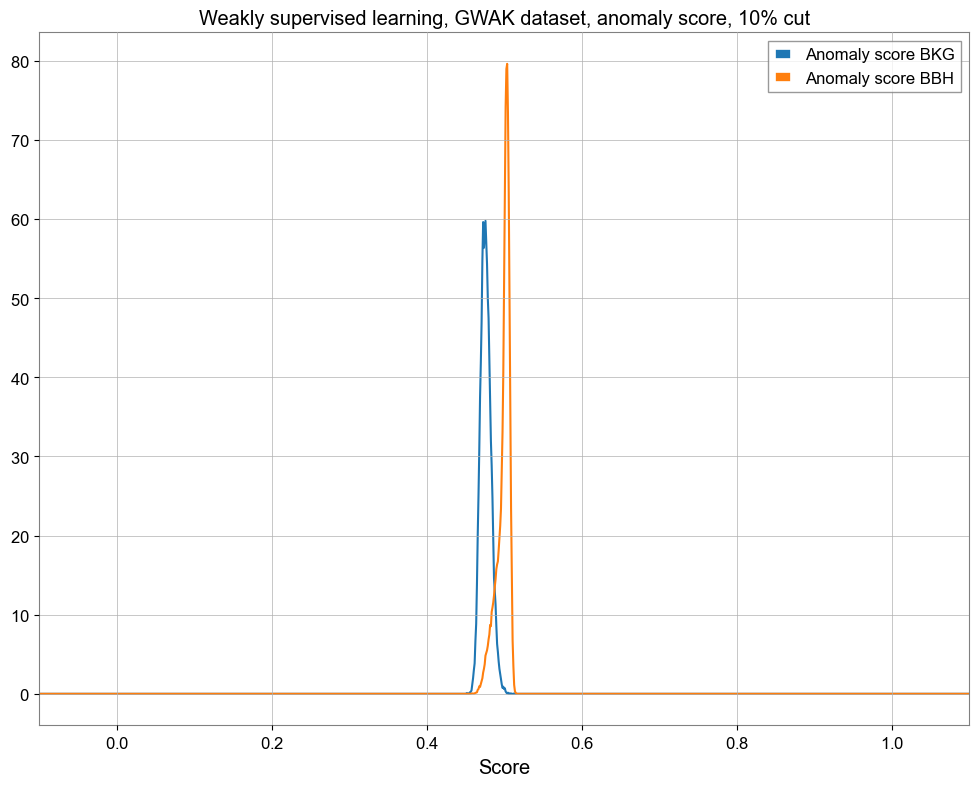

In [288]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.arange(-0.1, 1.1, 1e-3)

counts_train, bin_position_train = np.histogram(anomaly_score_bkg, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(anomaly_score_bbh, bins = bin_scheme, density = True)
# counts_signal, bin_position_signal = np.histogram(ReconstructedError_signalbbhData, bins = bin_scheme, density = True)
# counts_train_cut, bin_position_train_cut = np.histogram(ReconstructedError_train_cut_output_200d, bins = bin_scheme, density = True)

# counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_100d, bins = bin_scheme, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_100d, bins = bin_scheme, density = True)
# counts_glitches_real, bin_position_glitches_real = np.histogram(ReconstructedError_glitches_real_output_100d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
# bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_train_cut = (bin_position_train_cut[:-1] + bin_position_train_cut[1:]) / 2

# bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2
# bin_centers_glitches_real = (bin_position_glitches_real[:-1] + bin_position_glitches_real[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Anomaly score BKG')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Anomaly score BBH')
# plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_train_cut, counts_train_cut, color = colors[3], label = 'Training sample first 5e3')

# plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - simulated glitches')
# plt.plot(bin_centers_glitches_real, counts_glitches_real, color = colors[5], label = 'Signal sample - real glitches')


# plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
# plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
# plt.axvline(x = MSE_signalbbhData, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_train_cut_output_200d, color = colors[3], linestyle = '--', label = 'Training sample MSE first 5e3')

# plt.axvline(x = MSE_sinegaussian_output_100d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - simulated glitches')
# plt.axvline(x = MSE_glitches_real_output_100d, color = colors[5], linestyle = '--', label = 'Signal sample MSE - real glitches')


plt.xlim(-0.1, 1.1)
plt.xlabel('Score')
plt.title('Weakly supervised learning, GWAK dataset, anomaly score, 10% cut')
plt.legend()
plt.show()

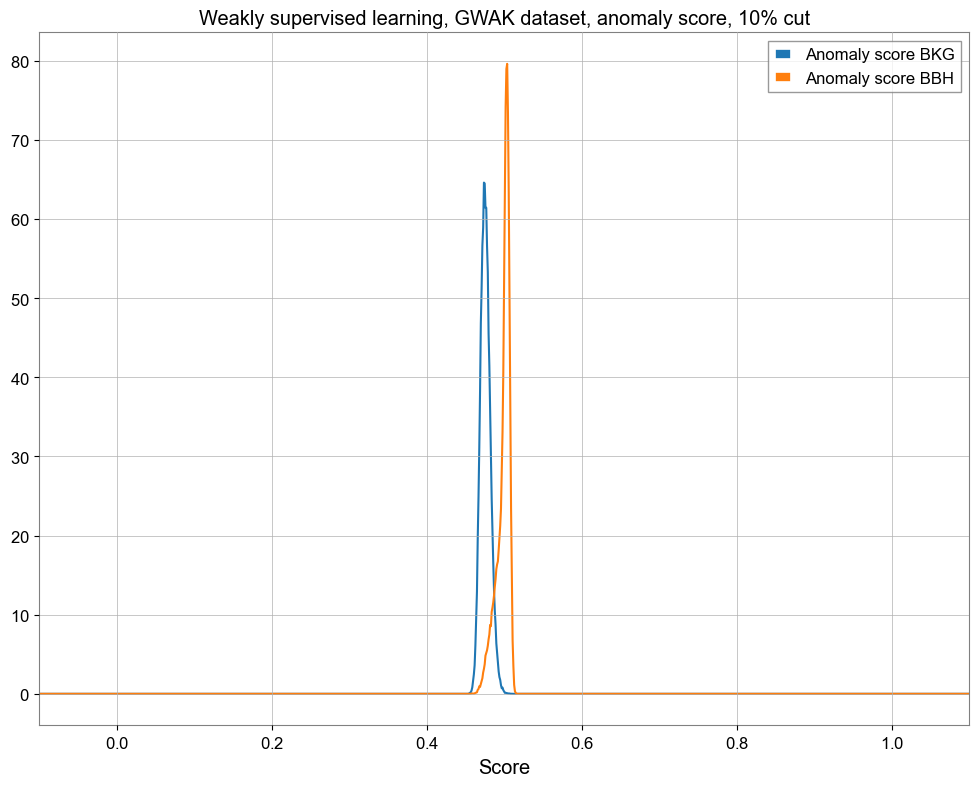

In [295]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.arange(-0.1, 1.1, 1e-3)

counts_train, bin_position_train = np.histogram(anomaly_score_bkg, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(anomaly_score_bbh, bins = bin_scheme, density = True)
# counts_signal, bin_position_signal = np.histogram(ReconstructedError_signalbbhData, bins = bin_scheme, density = True)
# counts_train_cut, bin_position_train_cut = np.histogram(ReconstructedError_train_cut_output_200d, bins = bin_scheme, density = True)

# counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_100d, bins = bin_scheme, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_100d, bins = bin_scheme, density = True)
# counts_glitches_real, bin_position_glitches_real = np.histogram(ReconstructedError_glitches_real_output_100d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
# bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_train_cut = (bin_position_train_cut[:-1] + bin_position_train_cut[1:]) / 2

# bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2
# bin_centers_glitches_real = (bin_position_glitches_real[:-1] + bin_position_glitches_real[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Anomaly score BKG')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Anomaly score BBH')
# plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_train_cut, counts_train_cut, color = colors[3], label = 'Training sample first 5e3')

# plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - simulated glitches')
# plt.plot(bin_centers_glitches_real, counts_glitches_real, color = colors[5], label = 'Signal sample - real glitches')


# plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
# plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
# plt.axvline(x = MSE_signalbbhData, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_train_cut_output_200d, color = colors[3], linestyle = '--', label = 'Training sample MSE first 5e3')

# plt.axvline(x = MSE_sinegaussian_output_100d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - simulated glitches')
# plt.axvline(x = MSE_glitches_real_output_100d, color = colors[5], linestyle = '--', label = 'Signal sample MSE - real glitches')


plt.xlim(-0.1, 1.1)
plt.xlabel('Score')
plt.title('Weakly supervised learning, GWAK dataset, anomaly score, 10% cut')
plt.legend()
plt.show()

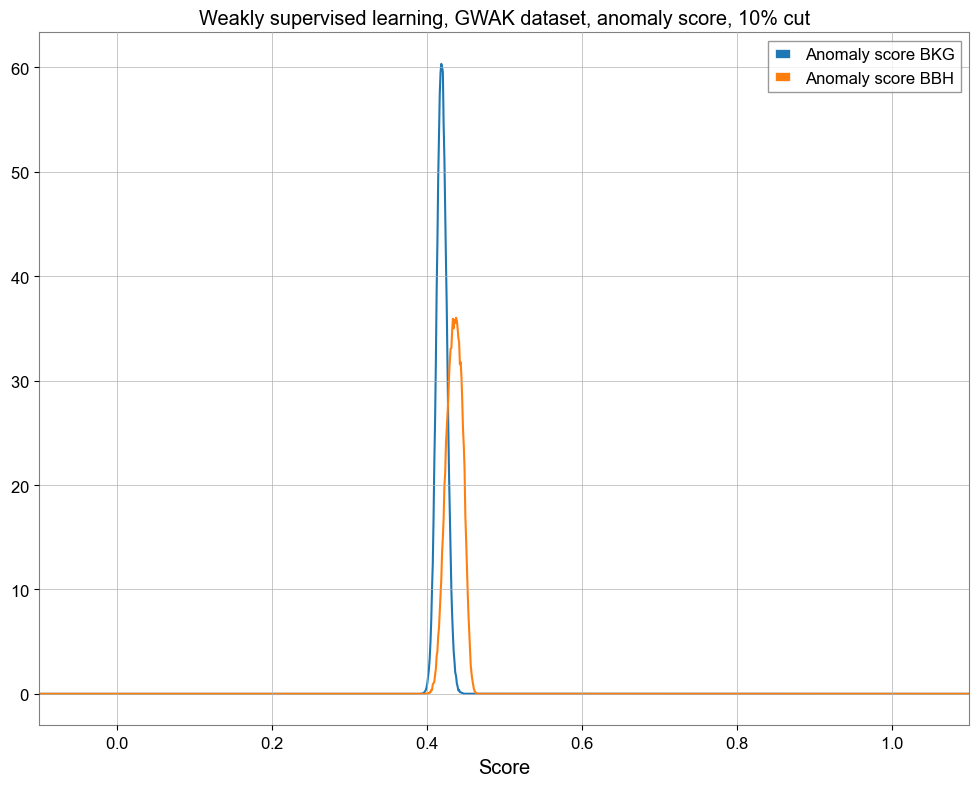

In [259]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.arange(-0.1, 1.1, 1e-3)

counts_train, bin_position_train = np.histogram(anomaly_score_bkg, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(anomaly_score_bbh, bins = bin_scheme, density = True)
# counts_signal, bin_position_signal = np.histogram(ReconstructedError_signalbbhData, bins = bin_scheme, density = True)
# counts_train_cut, bin_position_train_cut = np.histogram(ReconstructedError_train_cut_output_200d, bins = bin_scheme, density = True)

# counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_100d, bins = bin_scheme, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_100d, bins = bin_scheme, density = True)
# counts_glitches_real, bin_position_glitches_real = np.histogram(ReconstructedError_glitches_real_output_100d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
# bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_train_cut = (bin_position_train_cut[:-1] + bin_position_train_cut[1:]) / 2

# bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2
# bin_centers_glitches_real = (bin_position_glitches_real[:-1] + bin_position_glitches_real[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Anomaly score BKG')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Anomaly score BBH')
# plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_train_cut, counts_train_cut, color = colors[3], label = 'Training sample first 5e3')

# plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - simulated glitches')
# plt.plot(bin_centers_glitches_real, counts_glitches_real, color = colors[5], label = 'Signal sample - real glitches')


# plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
# plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
# plt.axvline(x = MSE_signalbbhData, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_train_cut_output_200d, color = colors[3], linestyle = '--', label = 'Training sample MSE first 5e3')

# plt.axvline(x = MSE_sinegaussian_output_100d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - simulated glitches')
# plt.axvline(x = MSE_glitches_real_output_100d, color = colors[5], linestyle = '--', label = 'Signal sample MSE - real glitches')


plt.xlim(-0.1, 1.1)
plt.xlabel('Score')
plt.title('Weakly supervised learning, GWAK dataset, anomaly score, 10% cut')
plt.legend()
plt.show()

In [78]:
def upperTPRFPRcalc(trainerror, signalerror, FPRlist):
    TPRlist = np.zeros(len(FPRlist))
    length_of_train_sample = len(trainerror)
    print(length_of_train_sample)
    length_of_signal_value = len(signalerror)
    print(length_of_signal_value)
    
    for i in range(len(FPRlist)):
        index_number = int(length_of_train_sample * FPRlist[i])
        threshold = np.sort(trainerror)[-index_number]
            
        print(threshold)
        print(np.argwhere(signalerror > threshold).shape)
        TPRlist[i] = np.argwhere(signalerror > threshold).shape[0] / length_of_signal_value
    
    TPRlist[-1] = 1
    
    return TPRlist

def lowerTPRFPRcalc(trainerror, signalerror, FPRlist):
    TPRlist = np.zeros(len(FPRlist))
    length_of_train_sample = len(trainerror)
    # print(length_of_train_sample)
    length_of_signal_value = len(signalerror)
    # print(length_of_signal_value)
    
    for i in range(len(FPRlist)):
        index_number = int(length_of_train_sample * FPRlist[i])
        if index_number == 0:
            threshold = np.sort(trainerror)[index_number]
        else:
            threshold = np.sort(trainerror)[index_number-1]
        # print(np.sort(trainerror))
        # print(threshold)
        # print(np.argwhere(signalerror < threshold).shape)
        TPRlist[i] = np.argwhere(signalerror < threshold).shape[0] / length_of_signal_value
    
    TPRlist[-1] = 1
    
    return TPRlist

In [84]:
FPR_list = np.logspace(-3,0,100)

In [85]:
TPR_list = upperTPRFPRcalc(anomaly_score_bkg.flatten(), anomaly_score_bbh.flatten(), FPR_list)

20020
100000
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
1.0
(81065, 1)
0.9999998807907104
(81584, 1)
0.9999998807907104
(81584, 1)
0.9999996423721313
(81944, 1)
0.9999992847442627
(82202, 1)
0.9999988079071045
(82394, 1)
0.9999971389770508
(82745, 1)
0.9999921321868896
(83152, 1)
0.9999780654907227
(83538, 1)
0.9999192953109741
(83979, 1)
0.9995974898338318
(84526, 1)
0.9985394477844238
(84914, 1)
0.9898155927658081
(85383, 1)
0.9462180137634277
(85780, 1)
0.4873679280

(0.0, 1.1)

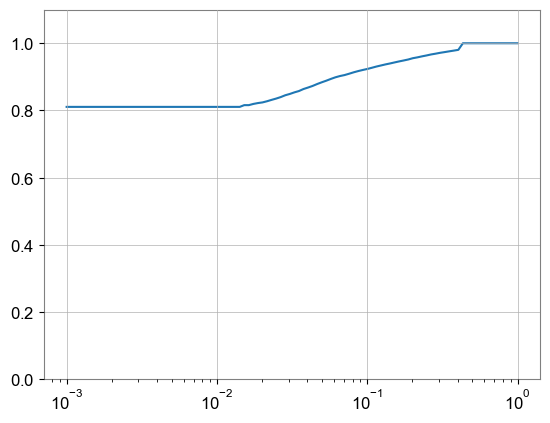

In [86]:
plt.plot(FPR_list, TPR_list)
plt.xscale('log')
plt.ylim(0,1.1)

100000
100000
0.19336162507534027
(20122, 1)
0.19226691126823425
(21987, 1)
0.19136469066143036
(23644, 1)
0.19063572585582733
(24959, 1)
0.18985615670681
(26436, 1)
0.18906833231449127
(27926, 1)
0.18827202916145325
(29513, 1)
0.18735724687576294
(31369, 1)
0.1865784227848053
(32972, 1)
0.18562820553779602
(35066, 1)
0.18464940786361694
(37281, 1)
0.18371081352233887
(39485, 1)
0.18279224634170532
(41756, 1)
0.18187415599822998
(44175, 1)
0.18100953102111816
(46554, 1)
0.18012762069702148
(49248, 1)
0.17929798364639282
(51946, 1)
0.1784989833831787
(54721, 1)
0.17777270078659058
(57444, 1)
0.17713789641857147
(60431, 1)
0.17679820954799652
(63098, 1)
0.17660176753997803
(65480, 1)
0.176454097032547
(67881, 1)
0.17632491886615753
(70476, 1)
0.1762005239725113
(73497, 1)
0.17607396841049194
(76803, 1)
0.17593780159950256
(80603, 1)
0.17577475309371948
(85269, 1)
0.1755470335483551
(90772, 1)
0.17271286249160767
(99918, 1)


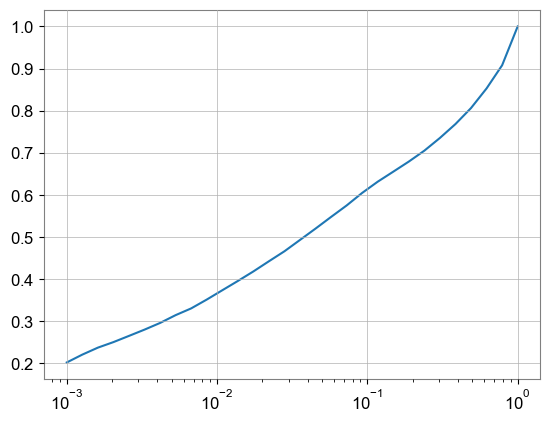

In [239]:
TPR_list = upperTPRFPRcalc(anomaly_score_bkg.flatten(), anomaly_score_bbh.flatten(), FPR_list)
plt.plot(FPR_list, TPR_list)
plt.xscale('log')

100000
100000
0.4408668875694275
(31023, 1)
0.4401010274887085
(33675, 1)
0.43951573967933655
(35706, 1)
0.43897730112075806
(37597, 1)
0.438397079706192
(39690, 1)
0.43780282139778137
(41825, 1)
0.43729034066200256
(43646, 1)
0.4366815686225891
(45850, 1)
0.43603193759918213
(48157, 1)
0.4353887140750885
(50420, 1)
0.43472999334335327
(52808, 1)
0.4340469241142273
(55186, 1)
0.4333491623401642
(57675, 1)
0.43262529373168945
(60252, 1)
0.4318884313106537
(62802, 1)
0.4311343729496002
(65298, 1)
0.4303603172302246
(67871, 1)
0.4295584559440613
(70459, 1)
0.42873871326446533
(73032, 1)
0.42783939838409424
(75737, 1)
0.4269014298915863
(78350, 1)
0.42591673135757446
(80980, 1)
0.4248620867729187
(83628, 1)
0.4236559271812439
(86417, 1)
0.42234277725219727
(89166, 1)
0.42083847522735596
(91717, 1)
0.41911107301712036
(94206, 1)
0.4169146716594696
(96462, 1)
0.4137468934059143
(98486, 1)
0.3927830457687378
(100000, 1)


(0.001, 1)

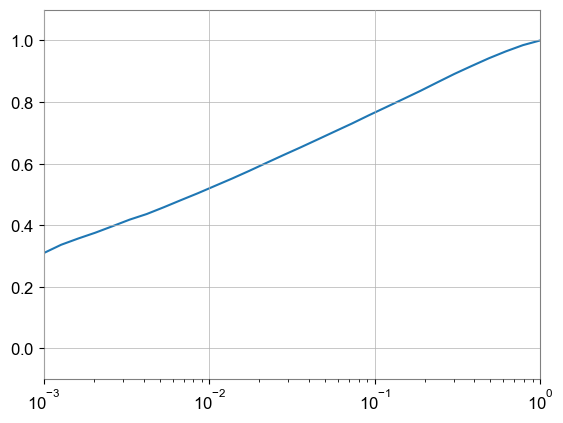

In [263]:
TPR_list = upperTPRFPRcalc(anomaly_score_bkg.flatten(), anomaly_score_bbh.flatten(), FPR_list)
plt.plot(FPR_list, TPR_list)
plt.xscale('log')
plt.ylim(-0.1,1.1)
plt.xlim(1e-3,1)

In [262]:
auc(FPR_list, TPR_list)

0.9057191698249779

20000
100000
0.5007436275482178
(52399, 1)
0.5004538893699646
(54291, 1)
0.4999154806137085
(57506, 1)
0.4994276762008667
(60105, 1)
0.49829962849617004
(65190, 1)
0.4976600408554077
(67458, 1)
0.4966094493865967
(70753, 1)
0.49587467312812805
(72771, 1)
0.4950953722000122
(74559, 1)
0.4942518472671509
(76371, 1)
0.4935058653354645
(77907, 1)
0.49266356229782104
(79484, 1)
0.4918738901615143
(80887, 1)
0.4909403622150421
(82464, 1)
0.49001544713974
(83959, 1)
0.4891258478164673
(85358, 1)
0.4882630407810211
(86625, 1)
0.4872574508190155
(88002, 1)
0.48618441820144653
(89364, 1)
0.4851582944393158
(90584, 1)
0.4841032922267914
(91730, 1)
0.48300302028656006
(92870, 1)
0.4817888140678406
(93929, 1)
0.4804939329624176
(95006, 1)
0.47907063364982605
(95996, 1)
0.47744879126548767
(96955, 1)
0.4756639301776886
(97883, 1)
0.4733946919441223
(98761, 1)
0.4703502357006073
(99458, 1)
0.4512886703014374
(100000, 1)


(0.001, 1)

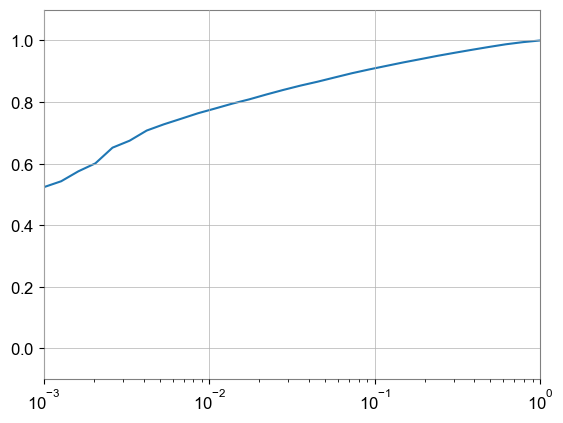

In [289]:
TPR_list = upperTPRFPRcalc(anomaly_score_bkg.flatten(), anomaly_score_bbh.flatten(), FPR_list)
plt.plot(FPR_list, TPR_list)
plt.xscale('log')
plt.ylim(-0.1,1.1)
plt.xlim(1e-3,1)

In [290]:
auc(FPR_list, TPR_list)

0.9624088905402743

20000
50000
0.4248450994491577
(27196, 1)
0.4243556559085846
(28666, 1)
0.4238722026348114
(30020, 1)
0.42307576537132263
(31863, 1)
0.4222199320793152
(33550, 1)
0.4209263324737549
(35515, 1)
0.4203081727027893
(36323, 1)
0.4195376932621002
(37179, 1)
0.41863134503364563
(38106, 1)
0.41775548458099365
(38924, 1)
0.41667166352272034
(39948, 1)
0.41569212079048157
(40753, 1)
0.4149797856807709
(41344, 1)
0.414142370223999
(42009, 1)
0.41324320435523987
(42684, 1)
0.412381112575531
(43341, 1)
0.41135650873184204
(44077, 1)
0.4104708433151245
(44616, 1)
0.4094434380531311
(45193, 1)
0.40827676653862
(45848, 1)
0.4071978032588959
(46402, 1)
0.4060778021812439
(46904, 1)
0.40486493706703186
(47384, 1)
0.4035855233669281
(47865, 1)
0.40222376585006714
(48272, 1)
0.4006744623184204
(48701, 1)
0.39890554547309875
(49097, 1)
0.3967105746269226
(49461, 1)
0.393513023853302
(49762, 1)
0.37574759125709534
(50000, 1)


(0.001, 1)

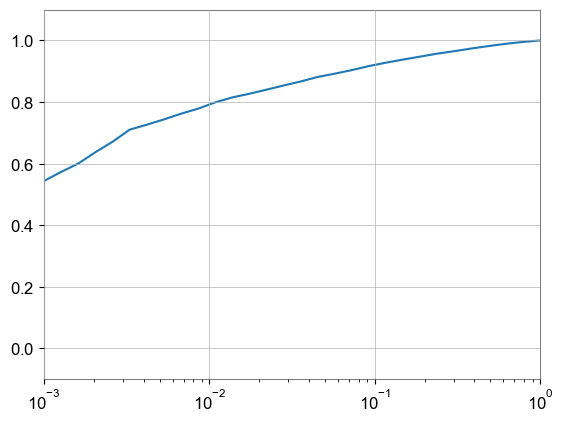

In [318]:
TPR_list = upperTPRFPRcalc(anomaly_score_bkg.flatten(), anomaly_score_bbh.flatten(), FPR_list)
plt.plot(FPR_list, TPR_list)
plt.xscale('log')
plt.ylim(-0.1,1.1)
plt.xlim(1e-3,1)

In [319]:
auc(FPR_list, TPR_list)

0.966814186553173

20000
100000
0.05320313572883606
(1798, 1)
0.05241698771715164
(2075, 1)
0.051557302474975586
(2403, 1)
0.050609830766916275
(2873, 1)
0.04959503933787346
(3434, 1)
0.0485026016831398
(4114, 1)
0.046889472752809525
(5566, 1)
0.04578963294625282
(6802, 1)
0.044861678034067154
(8119, 1)
0.04402237758040428
(9475, 1)
0.042921032756567
(11749, 1)
0.04216509684920311
(13488, 1)
0.041232090443372726
(16109, 1)
0.04039464145898819
(18997, 1)
0.039530713111162186
(22375, 1)
0.03851069137454033
(27140, 1)
0.03785496950149536
(30621, 1)
0.03706372529268265
(35458, 1)
0.036358870565891266
(40229, 1)
0.0356869250535965
(45296, 1)
0.03505566716194153
(50412, 1)
0.0343979075551033
(56193, 1)
0.0337684229016304
(61801, 1)
0.03318950906395912
(67114, 1)
0.03259478881955147
(72642, 1)
0.031976472586393356
(78074, 1)
0.03125615417957306
(83913, 1)
0.03040284663438797
(89575, 1)
0.029211292043328285
(95206, 1)
0.020955601707100868
(100000, 1)


0.777531424420252

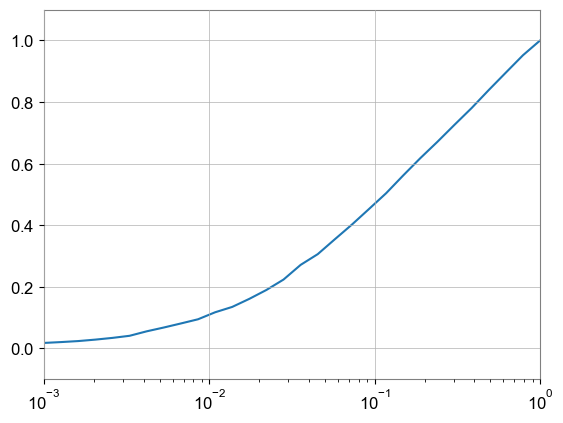

In [345]:
TPR_list = upperTPRFPRcalc(anomaly_score_bkg.flatten(), anomaly_score_bbh.flatten(), FPR_list)
plt.plot(FPR_list, TPR_list)
plt.xscale('log')
plt.ylim(-0.1,1.1)
plt.xlim(1e-3,1)
auc(FPR_list, TPR_list)

In [88]:
cached_data = np.loadtxt('../Data_cached/ROC_bbh.dat')

In [67]:
cached_data.shape

(643,)

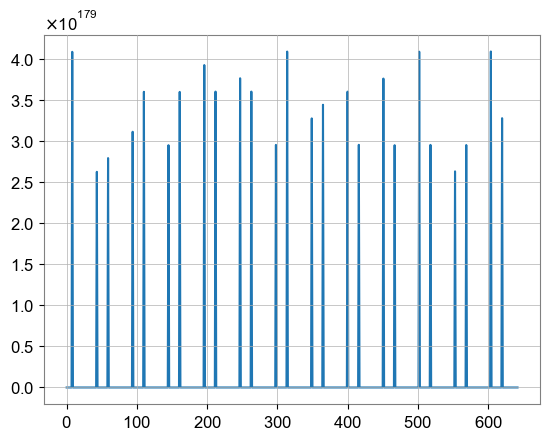

In [68]:
plt.plot(cached_data)

In [104]:
FPR_list = np.arange(0.001,1.001,0.001)

In [102]:
FPR_list

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
       0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18,
       0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27,
       0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36,
       0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44, 0.45,
       0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63,
       0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72,
       0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81,
       0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 ,
       0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

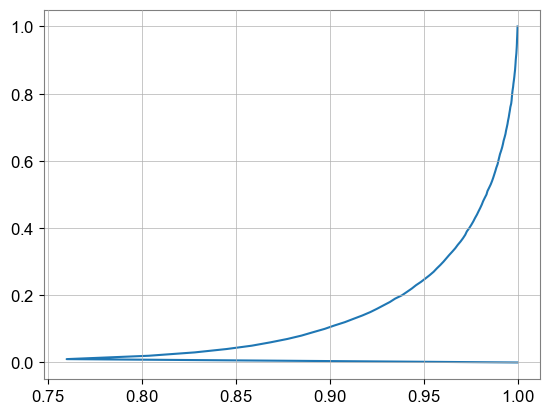

In [98]:
plt.plot(TPR_list_bbh, FPR_list)

In [161]:
AnomalyDetectionROCbbh = np.load('../Data_cached/ROC_bbh_anomaly_detection.npy') 
AnomalyDetectionROCsg = np.load('../Data_cached/ROC_sg_anomaly_detection.npy')

20020
100000
0.9996951818466187
(58102, 1)
0.9990683197975159
(63339, 1)
0.9982556700706482
(66125, 1)
0.996935248374939
(68620, 1)
0.9951575398445129
(70440, 1)
0.9929497241973877
(71994, 1)
0.9908933639526367
(73026, 1)
0.987511396408081
(74219, 1)
0.9835953712463379
(75234, 1)
0.980060338973999
(75989, 1)
0.9760026335716248
(76598, 1)
0.9718900918960571
(77145, 1)
0.9685021638870239
(77571, 1)
0.9647805690765381
(77955, 1)
0.9610307812690735
(78289, 1)
0.9546677470207214
(78837, 1)
0.9492201805114746
(79256, 1)
0.9417989253997803
(79776, 1)
0.9365960955619812
(80054, 1)
0.9311240315437317
(80358, 1)
0.9265322685241699
(80591, 1)
0.9221883416175842
(80773, 1)
0.9156531691551208
(81057, 1)
0.907853364944458
(81381, 1)
0.901042640209198
(81646, 1)
0.8972461223602295
(81781, 1)
0.8914318084716797
(81993, 1)
0.8843274116516113
(82244, 1)
0.875768780708313
(82475, 1)
0.8652694225311279
(82810, 1)
0.8573065996170044
(83032, 1)
0.8514633178710938
(83170, 1)
0.8423358798027039
(83397, 1)
0.8

Text(0.5, 1.0, 'ROC curve for weakly supervised model and full supervised model')

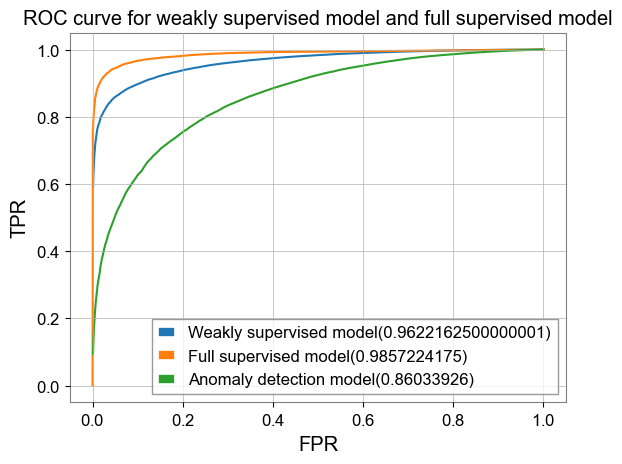

In [165]:
TPR_list_bbh = upperTPRFPRcalc(anomaly_score_bkg.flatten(), anomaly_score_bbh.flatten(), FPR_list)

plt.plot(FPR_list, TPR_list_bbh, label = 'Weakly supervised model('+str(auc(FPR_list, TPR_list_bbh))+')')
plt.plot(FulltrainingROCbbh[:,0], FulltrainingROCbbh[:,1], label = 'Full supervised model('+str(auc(FulltrainingROCbbh[:,0],FulltrainingROCbbh[:,1]))+')')
plt.plot(AnomalyDetectionROCbbh[1], AnomalyDetectionROCbbh[0], label = 'Anomaly detection model('+str(auc(AnomalyDetectionROCbbh[1],AnomalyDetectionROCbbh[0]))+')')

plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend()
plt.title('ROC curve for weakly supervised model and full supervised model')

20020
100000
1.0
(28318, 1)
1.0
(28318, 1)
0.9999998807907104
(29836, 1)
0.9999992847442627
(31828, 1)
0.9999978542327881
(33307, 1)
0.9999958276748657
(34199, 1)
0.9999912977218628
(35173, 1)
0.9999877214431763
(35619, 1)
0.999983549118042
(36020, 1)
0.9999728202819824
(36628, 1)
0.9999583959579468
(37182, 1)
0.9999301433563232
(37836, 1)
0.9999010562896729
(38293, 1)
0.9998621940612793
(38696, 1)
0.9997780919075012
(39274, 1)
0.9996891021728516
(39699, 1)
0.9995611310005188
(40120, 1)
0.9994764924049377
(40322, 1)
0.9993294477462769
(40602, 1)
0.9991210103034973
(40929, 1)
0.9989142417907715
(41191, 1)
0.9985718727111816
(41553, 1)
0.9981021285057068
(41913, 1)
0.9976977705955505
(42123, 1)
0.997094988822937
(42410, 1)
0.996547281742096
(42604, 1)
0.9958360195159912
(42813, 1)
0.9951164722442627
(43008, 1)
0.9941136240959167
(43253, 1)
0.993362545967102
(43399, 1)
0.9920672178268433
(43616, 1)
0.9908068776130676
(43795, 1)
0.9890546798706055
(44010, 1)
0.9877128601074219
(44146, 1)
0

Text(0.5, 1.0, 'ROC curve for weakly supervised model and full supervised model')

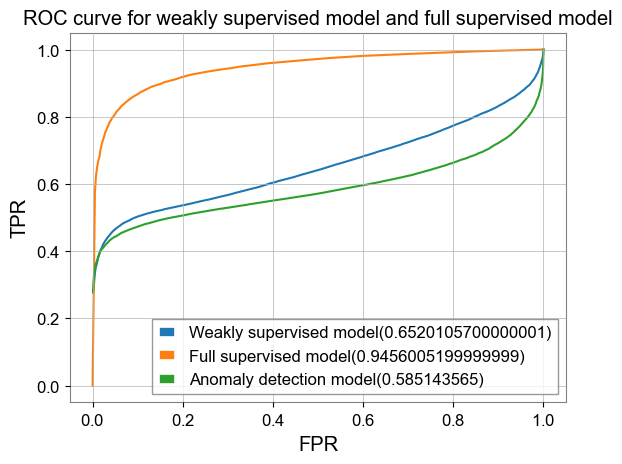

In [176]:
TPR_list_sg = upperTPRFPRcalc(anomaly_score_bkg.flatten(), anomaly_score_bbh.flatten(), FPR_list)

plt.plot(FPR_list, TPR_list_sg, label = 'Weakly supervised model('+str(auc(FPR_list, TPR_list_sg))+')')
plt.plot(FulltrainingROCsg[:,0], FulltrainingROCsg[:,1], label = 'Full supervised model('+str(auc(FulltrainingROCsg[:,0],FulltrainingROCsg[:,1]))+')')
plt.plot(AnomalyDetectionROCsg[1], AnomalyDetectionROCsg[0], label = 'Anomaly detection model('+str(auc(AnomalyDetectionROCsg[1],AnomalyDetectionROCsg[0]))+')')

plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend()
plt.title('ROC curve for weakly supervised model and full supervised model')